#### Import Libraries

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
pd.set_option('display.max_columns', None)

#### Define variables for column headers

In [123]:
# Data dict for column headers
df_columns = {
    0: 'engine_id', # There are 100 engine units
    1: 'cycle_time', # Time of use of engine in cycles
    2: 'op_set_1', # Operationl setting 1
    3: 'op_set_2', # Operationl setting 2
    4: 'op_set_3', # Operationl setting 3
    5: 'T2', # Total temperature at fan inlet
    6: 'T24', # Total temperature at low-pressure compressor outlet
    7: 'T30', # Total temperature at high-pressure compressor outlet
    8: 'T50', # Total temperature at low-pressure turbine outlet
    9: 'P2', # Pressure at fan inlet
    10: 'P15', # Pressure in bypass-duct
    11: 'P30', # Pressure at high-pressure compressor outlet
    12: 'Nf', # Physical fan speed
    13: 'Nc', # Physical core speed
    14: 'epr', # Engine pressure ratio (P50/P2)
    15: 'Ps30', # Static pressure at high-pressure compressor outlet
    16: 'phi', # Ratio of fuel flow to air mass flow
    17: 'NRf', # Corrected fan speed
    18: 'NRc', # Corrected core speed
    19: 'BPR', # Bypass ratio
    20: 'farB', # Burner fuel-air ratio
    21: 'htBleed', # Bleed enthalpy
    22: 'Nf_dmd', # Demanded fan speed
    23: 'PCNfR_dmd', # Demanded corrected fan speed
    24: 'W31', # HPT coolant bleed flow
    25: 'W32', # LPT coolant bleed flow
}

RUL_columns = {
    0: 'RUL' # Remaining useful life of engine in cycles
}

#### Load training, test and RUL data

In [125]:
df_train = pd.read_csv('train_FD001.txt', sep=r'\s+', header=None)
df_train.columns = list(df_columns.values())

df_test = pd.read_csv('test_FD001.txt', sep=r'\s+', header=None)
df_test.columns = list(df_columns.values())

df_RUL = pd.read_csv('RUL_FD001.txt', sep=r'\s+', header=None)
df_RUL.columns = list(RUL_columns.values())

print('Training dataset:', df_train.shape)
print('Test dataset:', df_test.shape)
print('Number of RUL:', df_RUL.shape)

Training dataset: (20631, 26)
Test dataset: (13096, 26)
Number of RUL: (100, 1)


#### Paramters to measure engine health and failure

In [127]:
def compute_RUL(df):
    '''
    Computes parameters or features to evaluate engine health:
    - EOL: end of life (max cycle per engine)
    - RUL: remaining useful life
    
    Returns a new dataframe with EOL, and RUL as columns.
    '''
    
    # Determine EOL - end of life (or maximum cycle time) per engine unit
    df['EOL'] = df.groupby('engine_id')['cycle_time'].transform('max')

    # Compute RUL - remaining useful life of each engine
    df['RUL'] = df['EOL'] - df['cycle_time']
    
    return df

compute_RUL(df_train)

engine_id  cycle_time  op_set_1  op_set_2  op_set_3      T2     T24  \
0              1           1   -0.0007   -0.0004     100.0  518.67  641.82   
1              1           2    0.0019   -0.0003     100.0  518.67  642.15   
2              1           3   -0.0043    0.0003     100.0  518.67  642.35   
3              1           4    0.0007    0.0000     100.0  518.67  642.35   
4              1           5   -0.0019   -0.0002     100.0  518.67  642.37   
...          ...         ...       ...       ...       ...     ...     ...   
20626        100         196   -0.0004   -0.0003     100.0  518.67  643.49   
20627        100         197   -0.0016   -0.0005     100.0  518.67  643.54   
20628        100         198    0.0004    0.0000     100.0  518.67  643.42   
20629        100         199   -0.0011    0.0003     100.0  518.67  643.23   
20630        100         200   -0.0032   -0.0005     100.0  518.67  643.85   

           T30      T50     P2    P15     P30       Nf       Nc  epr   Ps30  \
0      1589.70  1400.60  14.62  21.61  554.36  2388.06  9046.19  1.3  47.47   
1      1591.82  1403.14  14.62  21.61  553.75  2388.04  9044.07  1.3  47.49   
2      1587.99  1404.20  14.62  21.61  554.26  2388.08  9052.94  1.3  47.27   
3      1582.79  1401.87  14.62  21.61  554.45  2388.11  9049.48  1.3  47.13   
4      1582.85  1406.22  14.62  21.61  554.00  2388.06  9055.15  1.3  47.28   
...        ...      ...    ...    ...     ...      ...      ...  ...    ...   
20626  1597.98  1428.63  14.62  21.61  551.43  2388.19  9065.52  1.3  48.07   
20627  1604.50  1433.58  14.62  21.61  550.86  2388.23  9065.11  1.3  48.04   
20628  1602.46  1428.18  14.62  21.61  550.94  2388.24  9065.90  1.3  48.09   
20629  1605.26  1426.53  14.62  21.61  550.68  2388.25  9073.72  1.3  48.39   
20630  1600.38  1432.14  14.62  21.61  550.79  2388.26  9061.48  1.3  48.20   

          phi      NRf      NRc     BPR  farB  htBleed  Nf_dmd  PCNfR_dmd  \
0      521.66  2388.02  8138.62  8.4195  0.03      392    2388      100.0   
1      522.28  2388.07  8131.49  8.4318  0.03      392    2388      100.0   
2      522.42  2388.03  8133.23  8.4178  0.03      390    2388      100.0   
3      522.86  2388.08  8133.83  8.3682  0.03      392    2388      100.0   
4      522.19  2388.04  8133.80  8.4294  0.03      393    2388      100.0   
...       ...      ...      ...     ...   ...      ...     ...        ...   
20626  519.49  2388.26  8137.60  8.4956  0.03      397    2388      100.0   
20627  519.68  2388.22  8136.50  8.5139  0.03      395    2388      100.0   
20628  520.01  2388.24  8141.05  8.5646  0.03      398    2388      100.0   
20629  519.67  2388.23  8139.29  8.5389  0.03      395    2388      100.0   
20630  519.30  2388.26  8137.33  8.5036  0.03      396    2388      100.0   

         W31      W32  EOL  RUL  
0      39.06  23.4190  192  191  
1      39.00  23.4236  192  190  
2      38.95  23.3442  192  189  
3      38.88  23.3739  192  188  
4      38.90  23.4044  192  187  
...      ...      ...  ...  ...  
20626  38.49  22.9735  200    4  
20627  38.30  23.1594  200    3  
20628  38.44  22.9333  200    2  
20629  38.29  23.0640  200    1  
20630  38.37  23.0522  200    0  

[20631 rows x 28 columns]

#### Exploratory Data Analysis

In [129]:
df_train['engine_id'].nunique()

100

In [130]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   engine_id   20631 non-null  int64  
 1   cycle_time  20631 non-null  int64  
 2   op_set_1    20631 non-null  float64
 3   op_set_2    20631 non-null  float64
 4   op_set_3    20631 non-null  float64
 5   T2          20631 non-null  float64
 6   T24         20631 non-null  float64
 7   T30         20631 non-null  float64
 8   T50         20631 non-null  float64
 9   P2          20631 non-null  float64
 10  P15         20631 non-null  float64
 11  P30         20631 non-null  float64
 12  Nf          20631 non-null  float64
 13  Nc          20631 non-null  float64
 14  epr         20631 non-null  float64
 15  Ps30        20631 non-null  float64
 16  phi         20631 non-null  float64
 17  NRf         20631 non-null  float64
 18  NRc         20631 non-null  float64
 19  BPR         20631 non-nul

In [131]:
df_train.duplicated().sum()

0

In [132]:
df_train.describe()

engine_id    cycle_time      op_set_1      op_set_2  op_set_3  \
count  20631.000000  20631.000000  20631.000000  20631.000000   20631.0   
mean      51.506568    108.807862     -0.000009      0.000002     100.0   
std       29.227633     68.880990      0.002187      0.000293       0.0   
min        1.000000      1.000000     -0.008700     -0.000600     100.0   
25%       26.000000     52.000000     -0.001500     -0.000200     100.0   
50%       52.000000    104.000000      0.000000      0.000000     100.0   
75%       77.000000    156.000000      0.001500      0.000300     100.0   
max      100.000000    362.000000      0.008700      0.000600     100.0   

                 T2           T24           T30           T50            P2  \
count  2.063100e+04  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   5.186700e+02    642.680934   1590.523119   1408.933782  1.462000e+01   
std    6.537152e-11      0.500053      6.131150      9.000605  3.394700e-12   
min    5.186700e+02    641.210000   1571.040000   1382.250000  1.462000e+01   
25%    5.186700e+02    642.325000   1586.260000   1402.360000  1.462000e+01   
50%    5.186700e+02    642.640000   1590.100000   1408.040000  1.462000e+01   
75%    5.186700e+02    643.000000   1594.380000   1414.555000  1.462000e+01   
max    5.186700e+02    644.530000   1616.910000   1441.490000  1.462000e+01   

                P15           P30            Nf            Nc           epr  \
count  20631.000000  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean      21.609803    553.367711   2388.096652   9065.242941  1.300000e+00   
std        0.001389      0.885092      0.070985     22.082880  4.660829e-13   
min       21.600000    549.850000   2387.900000   9021.730000  1.300000e+00   
25%       21.610000    552.810000   2388.050000   9053.100000  1.300000e+00   
50%       21.610000    553.440000   2388.090000   9060.660000  1.300000e+00   
75%       21.610000    554.010000   2388.140000   9069.420000  1.300000e+00   
max       21.610000    556.060000   2388.560000   9244.590000  1.300000e+00   

               Ps30           phi           NRf           NRc           BPR  \
count  20631.000000  20631.000000  20631.000000  20631.000000  20631.000000   
mean      47.541168    521.413470   2388.096152   8143.752722      8.442146   
std        0.267087      0.737553      0.071919     19.076176      0.037505   
min       46.850000    518.690000   2387.880000   8099.940000      8.324900   
25%       47.350000    520.960000   2388.040000   8133.245000      8.414900   
50%       47.510000    521.480000   2388.090000   8140.540000      8.438900   
75%       47.700000    521.950000   2388.140000   8148.310000      8.465600   
max       48.530000    523.380000   2388.560000   8293.720000      8.584800   

               farB       htBleed   Nf_dmd  PCNfR_dmd           W31  \
count  2.063100e+04  20631.000000  20631.0    20631.0  20631.000000   
mean   3.000000e-02    393.210654   2388.0      100.0     38.816271   
std    1.556432e-14      1.548763      0.0        0.0      0.180746   
min    3.000000e-02    388.000000   2388.0      100.0     38.140000   
25%    3.000000e-02    392.000000   2388.0      100.0     38.700000   
50%    3.000000e-02    393.000000   2388.0      100.0     38.830000   
75%    3.000000e-02    394.000000   2388.0      100.0     38.950000   
max    3.000000e-02    400.000000   2388.0      100.0     39.430000   

                W32           EOL           RUL  
count  20631.000000  20631.000000  20631.000000  
mean      23.289705    216.615724    107.807862  
std        0.108251     50.028600     68.880990  
min       22.894200    128.000000      0.000000  
25%       23.221800    185.000000     51.000000  
50%       23.297900    207.000000    103.000000  
75%       23.366800    240.000000    155.000000  
max       23.618400    362.000000    361.000000

##### Initial observations
- There are 100 unique engines from which data was collected
- There are no null or duplicate values in the training dataset

A few columns immediately standout as having weak to no predictive power based on their std values: 
1. op_set_3
2. T2
3. P2
4. P15
5. epr
6. farB
7. Nf_dmd
8. PCNfR_dmd

#### Visualizations

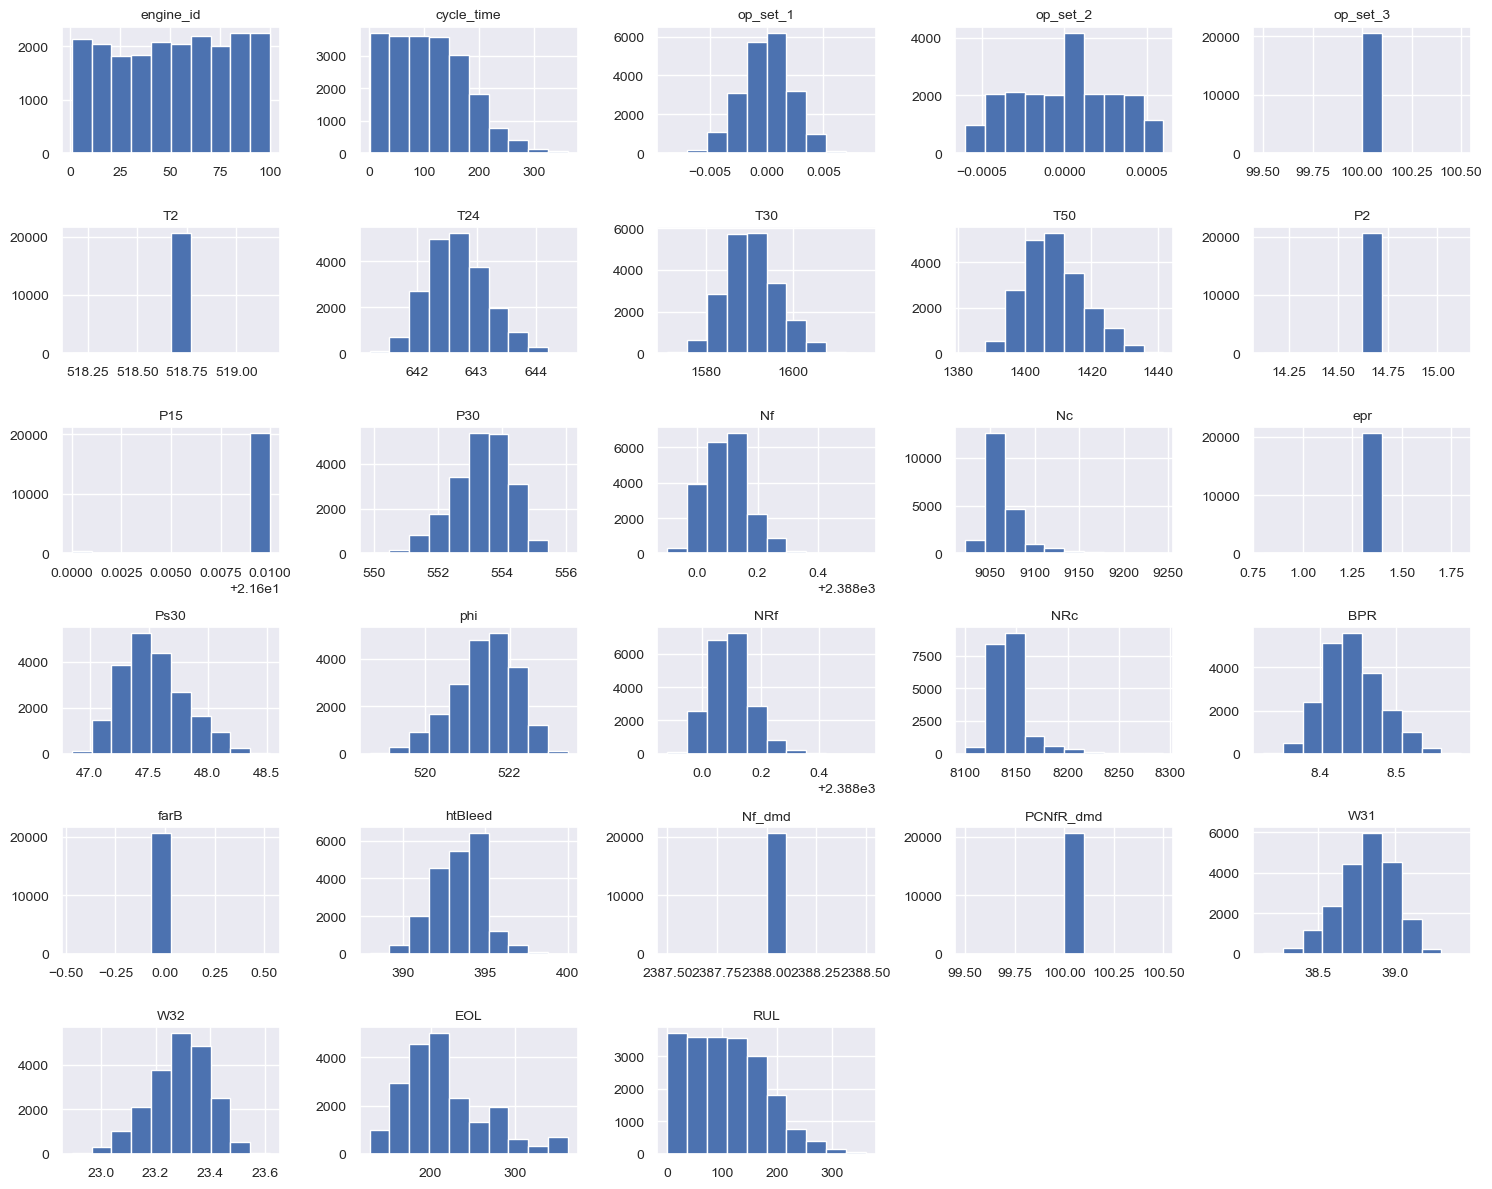

In [135]:
# Set rc params
plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=10)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Histoplots of features
df_train.hist(bins=10, figsize=(15,12))
plt.tight_layout()
plt.show()

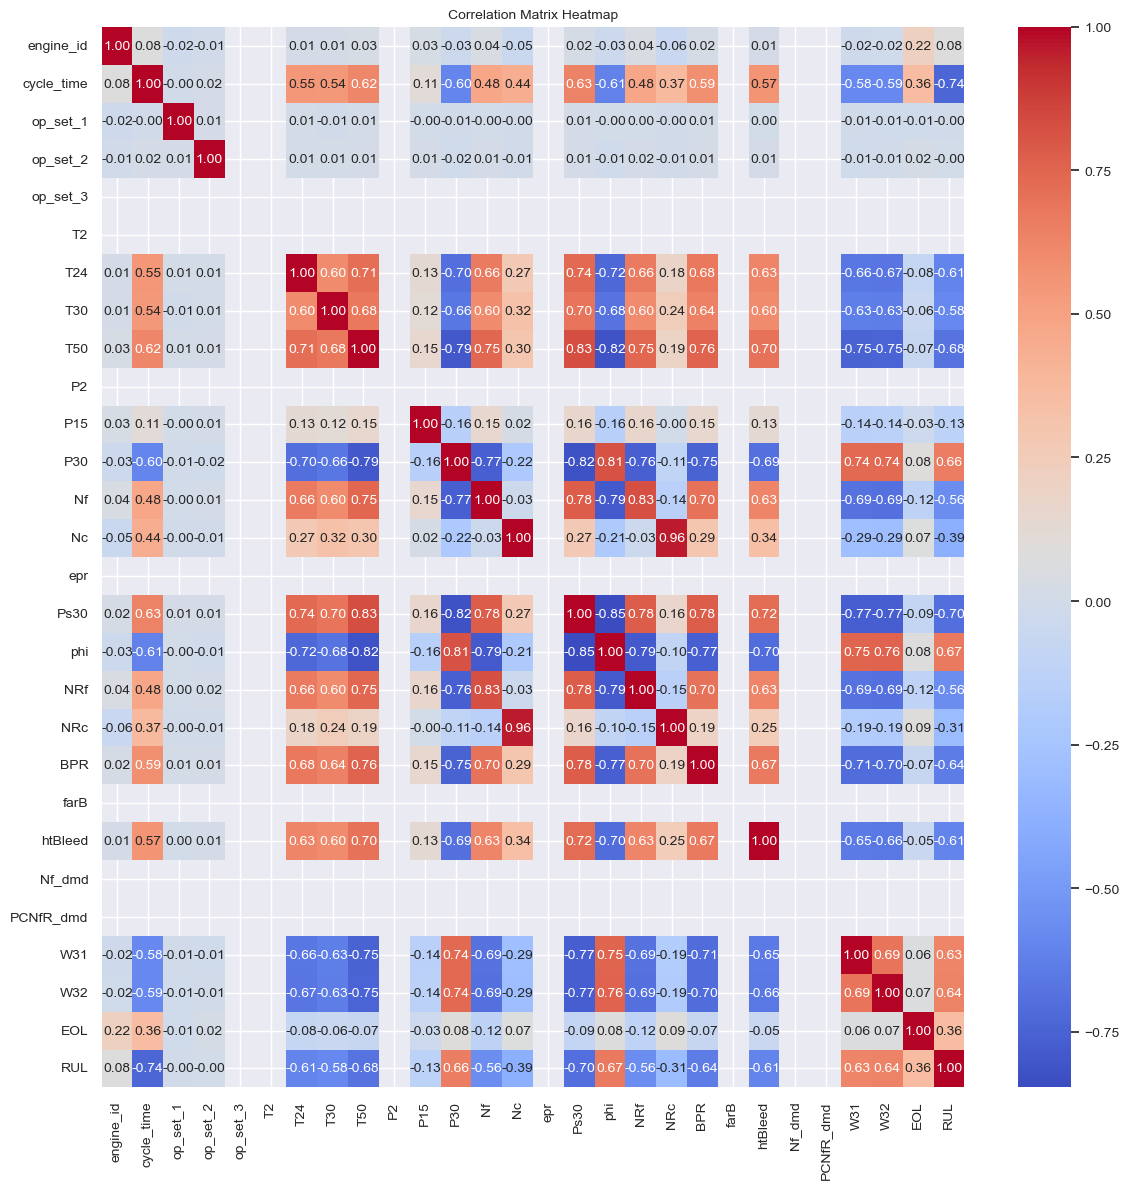

In [136]:
# Create correlation heatmap
corr_matrix = df_train.corr()

plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

A number of columns would have little to no predictive based on their std values, histograms and correlation with RUL (target variable).

Features_to_drop = ['op_set_1', 'op_set_2', 'op_set_3', 'T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd', 'EOL']

Features to explore: cycle_time, T24, T30, T50, P30, Ps30, phi, BPR, htBleed, W31, W32

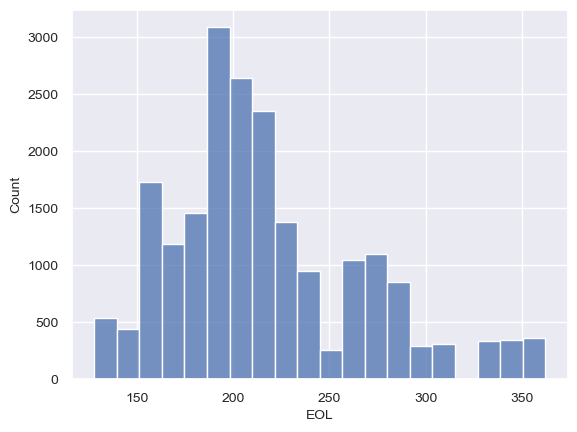

In [138]:
# Engine failure cycle times
plt.figure()
sns.histplot(df_train['EOL'], bins=20)
plt.show()

In [139]:
# Mean, median and maximum engine cycles
print('mean', 'median', 'max')
df_train['cycle_time'].mean(), df_train['cycle_time'].median(), df_train['cycle_time'].max()

mean median max


(108.80786195530997, 104.0, 362)

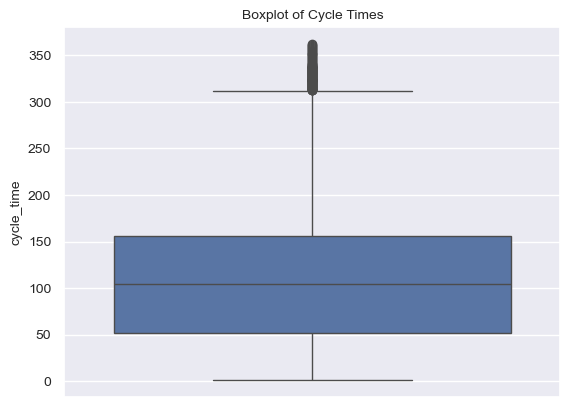

In [140]:
# Boxplot of cycle times
sns.boxplot(df_train['cycle_time'])
plt.title('Boxplot of Cycle Times')
plt.show()

##### There are outlier values that need to be dealt with.

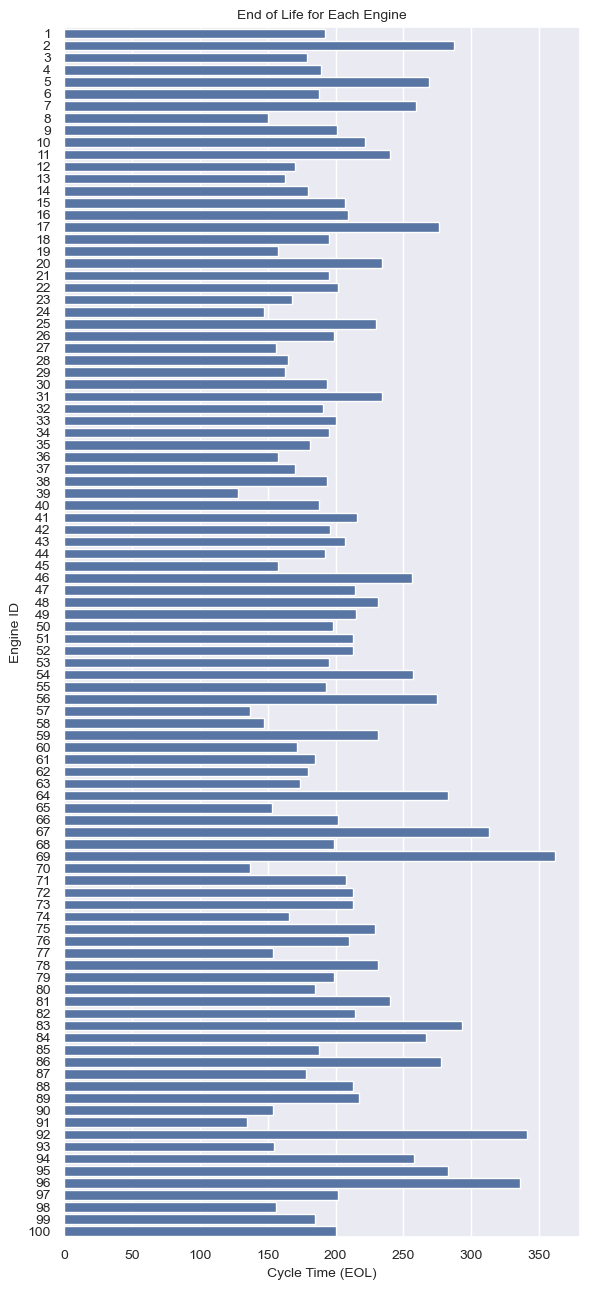

In [142]:
# Plot of maximum cycle or end of life for each engine unit
eol_df = df_train.groupby('engine_id')['cycle_time'].max().reset_index()

plt.figure(figsize=(6, 13))
sns.barplot(y='engine_id', x='cycle_time', data=eol_df, orient='h')
plt.title('End of Life for Each Engine')
plt.ylabel('Engine ID')
plt.xlabel('Cycle Time (EOL)')
plt.tight_layout()
plt.show()

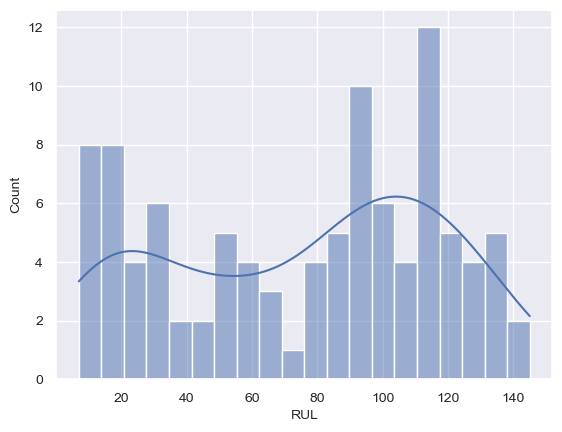

In [143]:
# Test RUL distributon
plt.figure()
sns.histplot(df_RUL['RUL'], kde=True, bins=20)
plt.show()

##### Handle Outliers

In [145]:
features = ['cycle_time', 'T24', 'T30', 'T50', 'P30', 'Ps30', 'phi', 'BPR', 'htBleed', 'W31', 'W32', 'EOL'] 

def remove_outliers(df, columns):
    '''
    Removes outliers from selected features using IQR.
    
    Returns a dataframe without outliers.
    '''
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]

    return df.reset_index(drop=True)

df_train = remove_outliers(df_train, features)

##### Feature Visualization

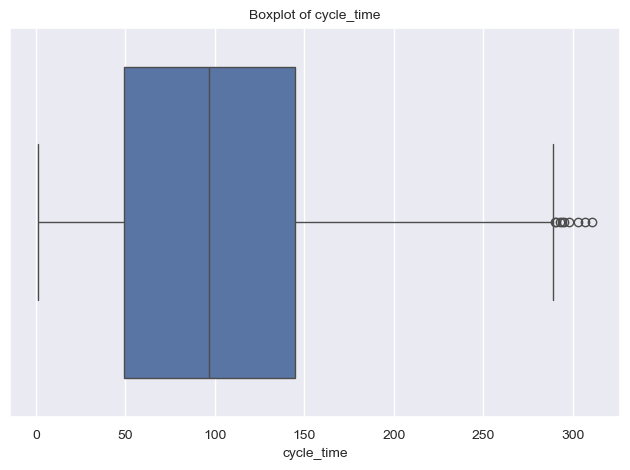

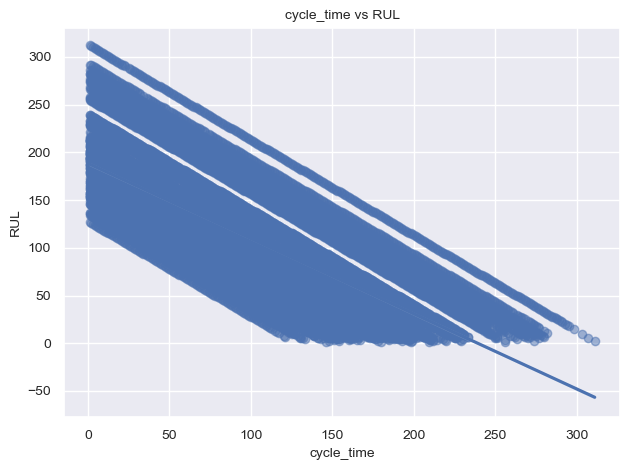

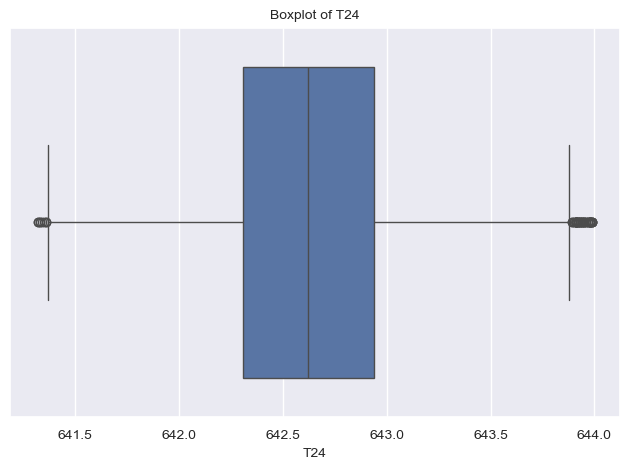

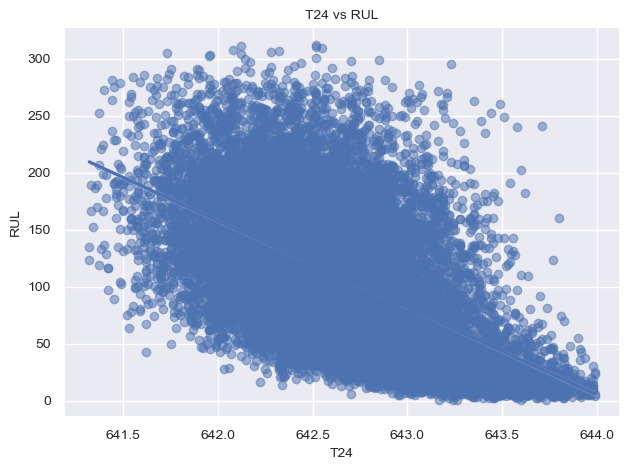

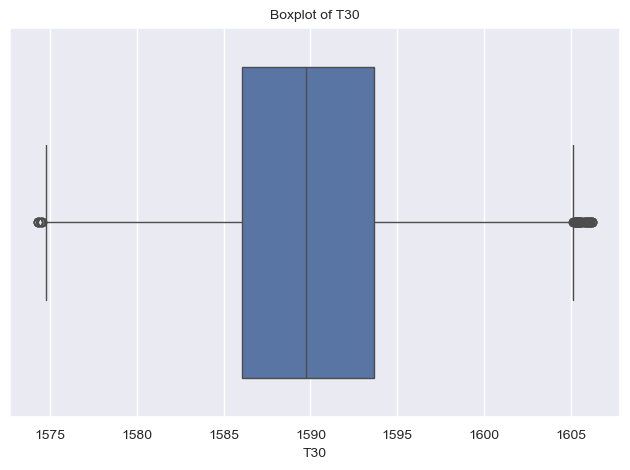

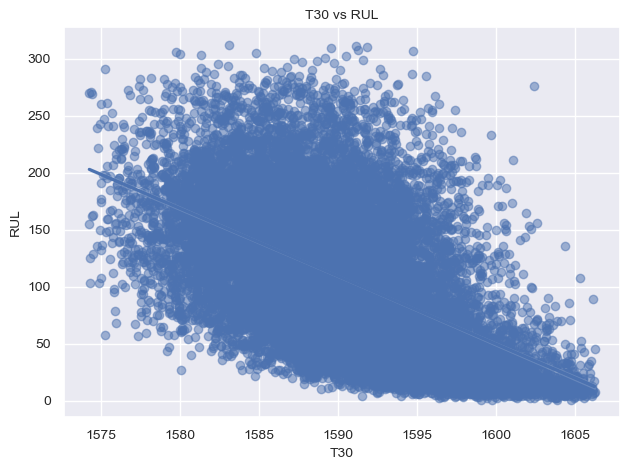

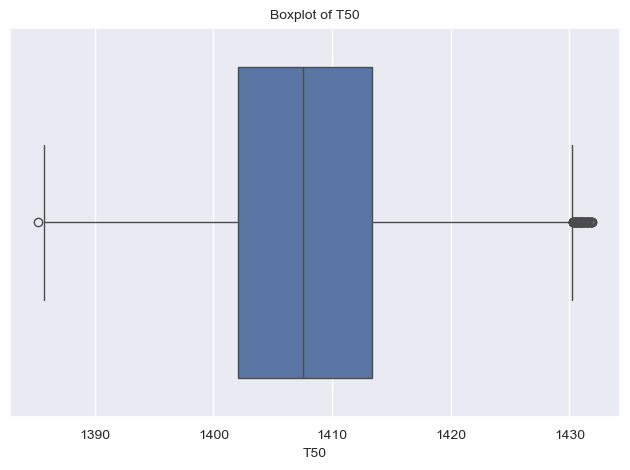

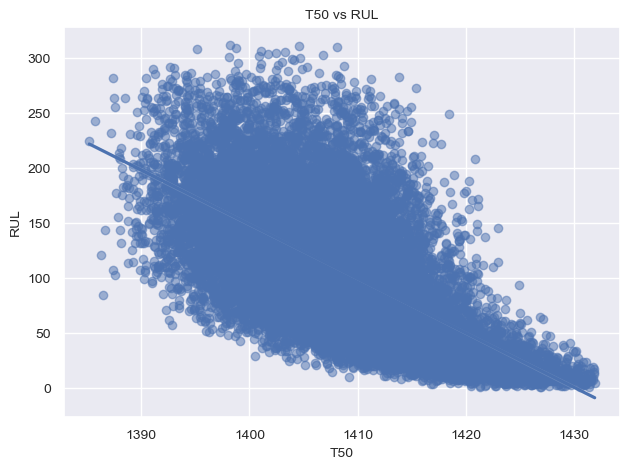

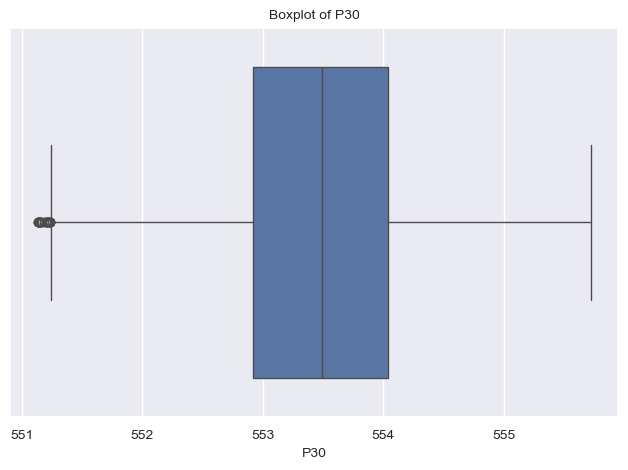

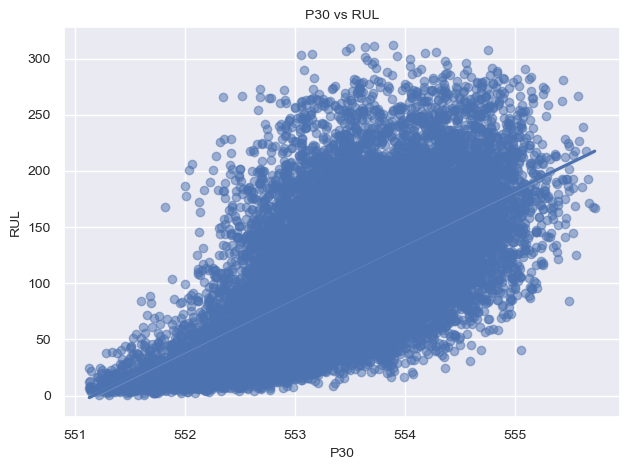

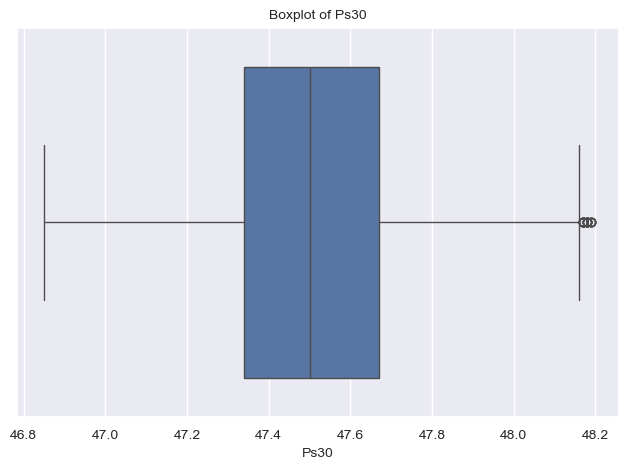

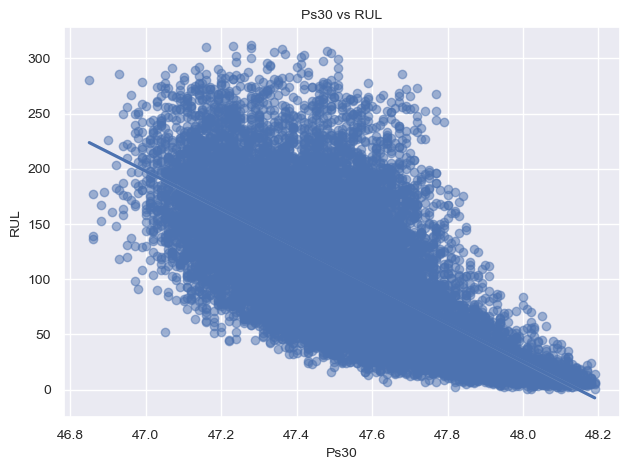

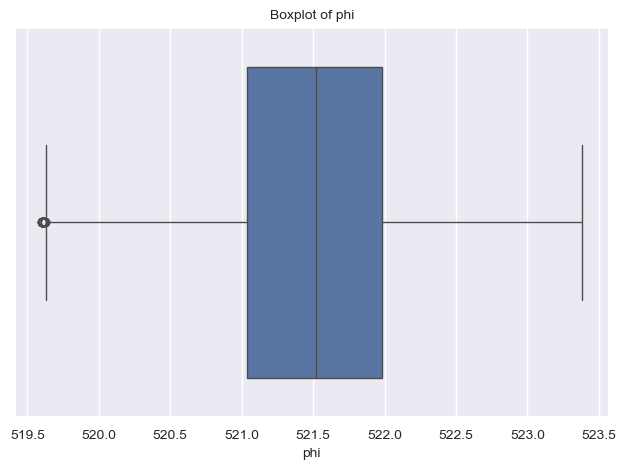

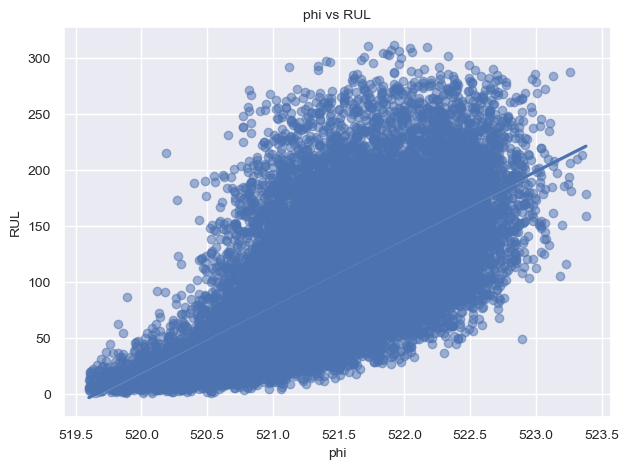

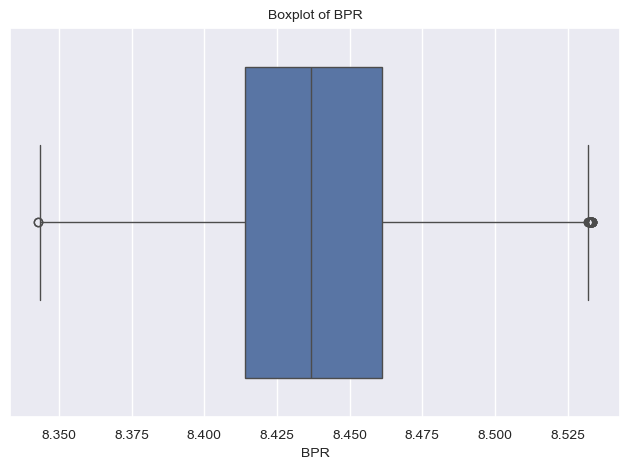

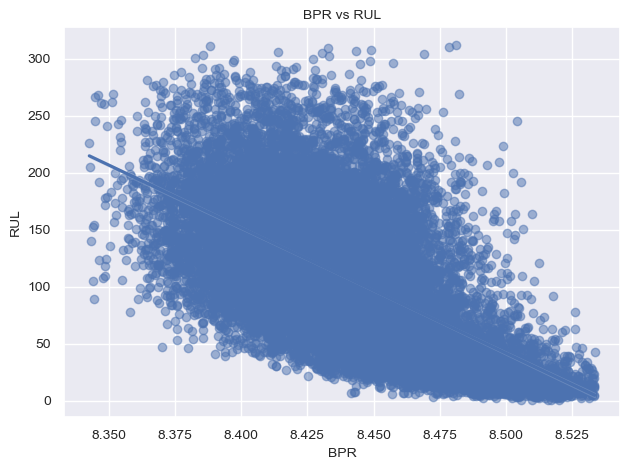

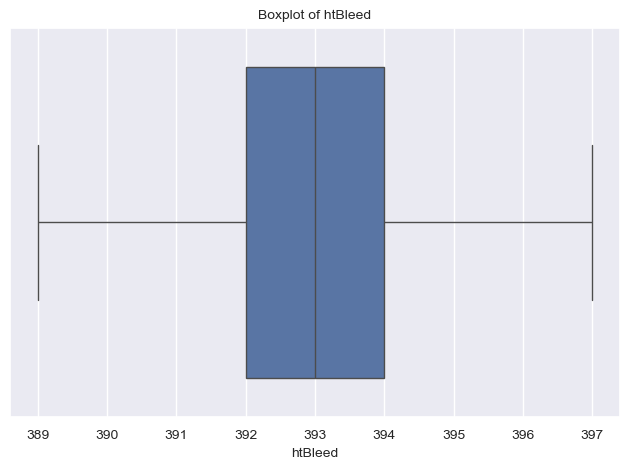

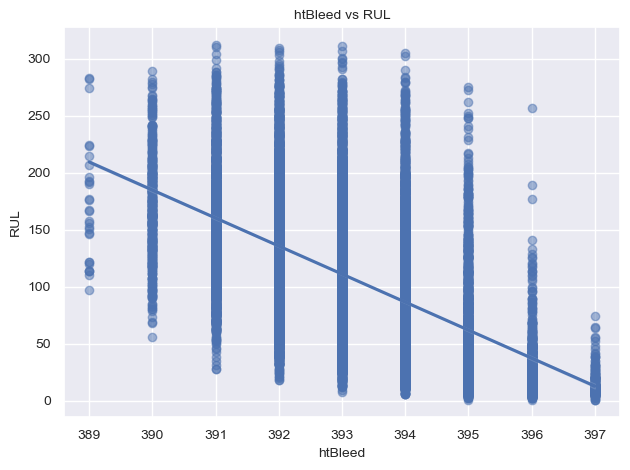

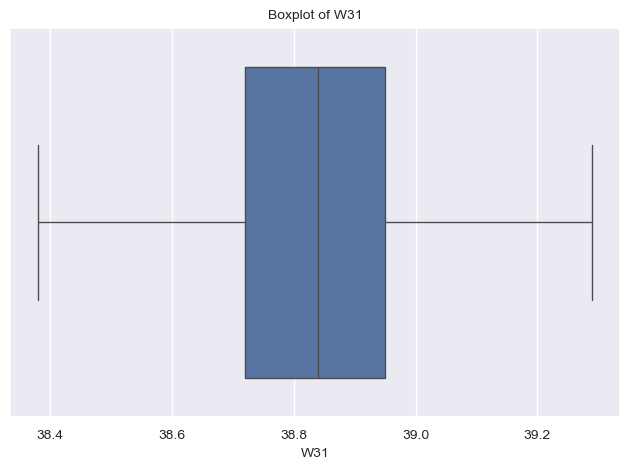

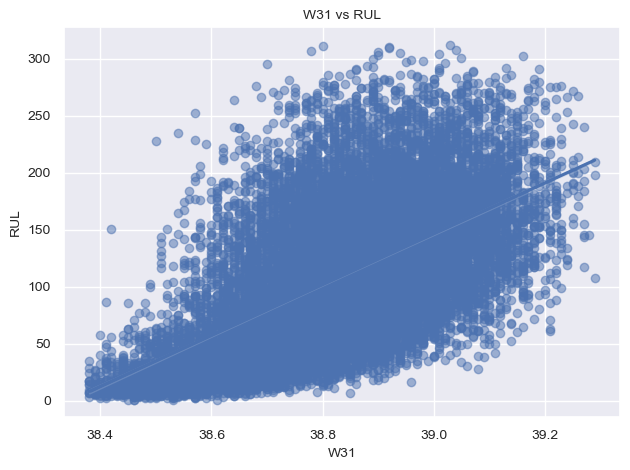

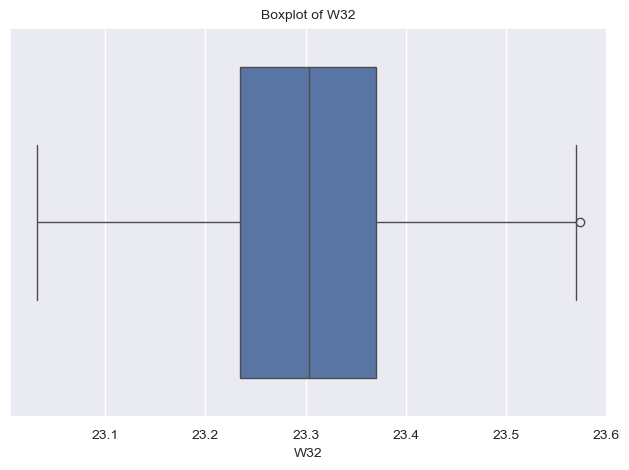

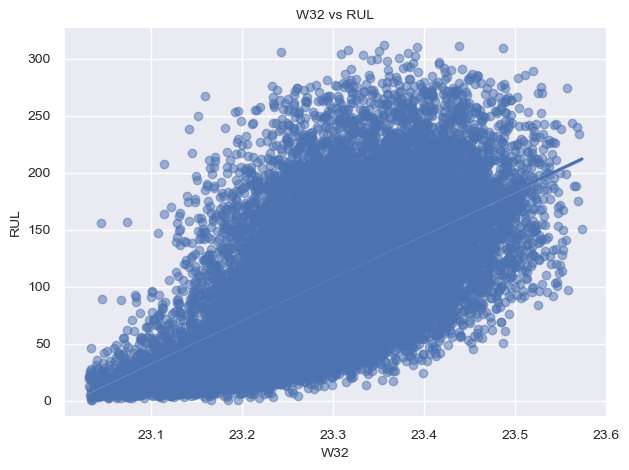

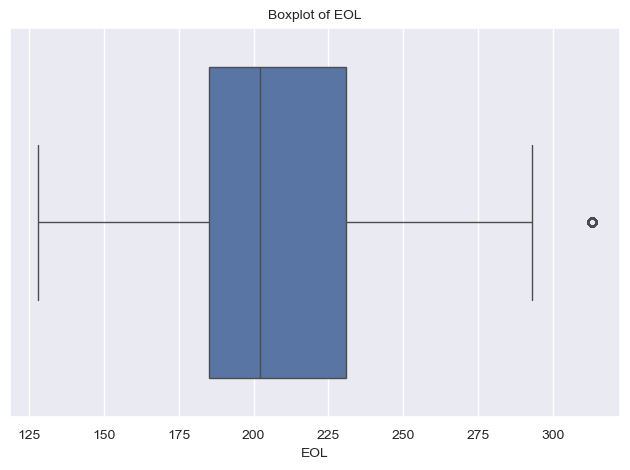

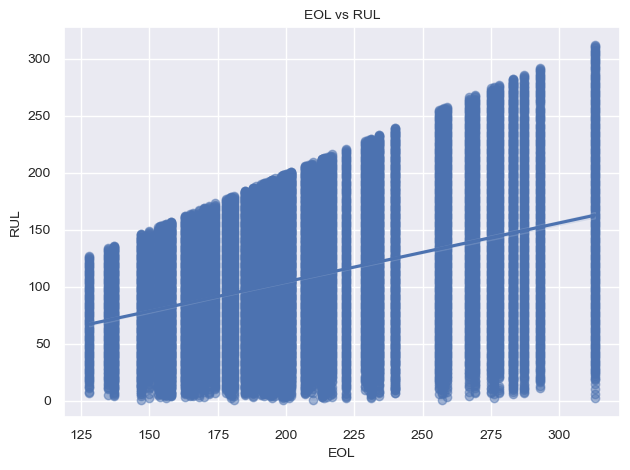

In [147]:
def visualise_features(df, features):
    '''
    Visualize features from the dataframe.

    Returns boxplot for feature; and scatterplot of feature vs RUL.
    '''
    
    for feature in features:
        # Boxplot
        sns.boxplot(x=df[feature])
        plt.title(f'Boxplot of {feature}')
        plt.xlabel(feature)
        plt.tight_layout()
        plt.show()

        # Scatterplot with regression line
        sns.regplot(x=df[feature], y=df['RUL'], scatter_kws={'alpha': 0.5})
        plt.title(f'{feature} vs RUL')
        plt.xlabel(feature)
        plt.ylabel('RUL')
        plt.tight_layout()
        plt.show()

visualise_features(df_train, features)

##### Sensor Patterns Visualization

In [149]:
# Explore sensor data for engines with the shortest and longest EOL
eol = df_train.groupby('engine_id')['EOL'].max()

# Get the 2 engines with the shortest EOL (smallest EOL values)
shortest = eol.sort_values()[:2].index.to_list()

# Get the 2 engines with the longest EOL (largest EOL values)
longest = eol.sort_values(ascending=False)[:2].index.to_list()

# Concatenate the lists of engines with shortest and longest EOL
engines = shortest + longest
print('Engines to explore sensor reading:', engines)

Engines to explore sensor reading: [39, 91, 67, 83]


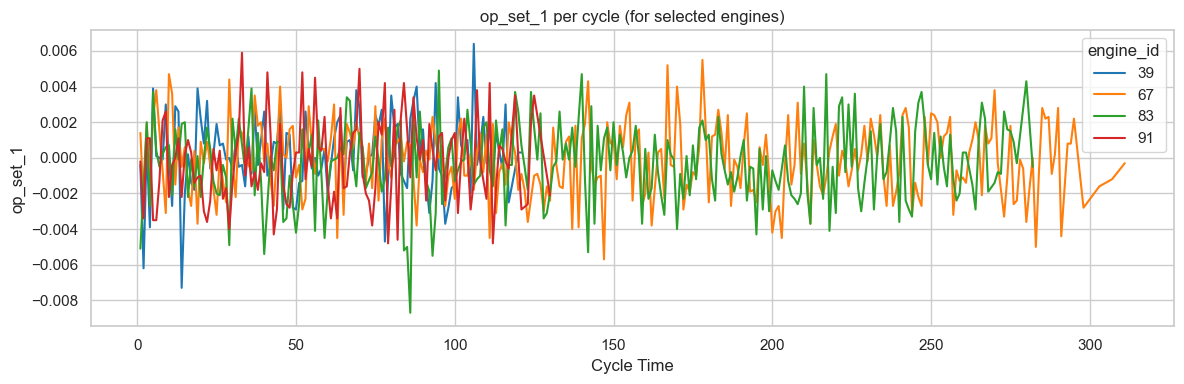

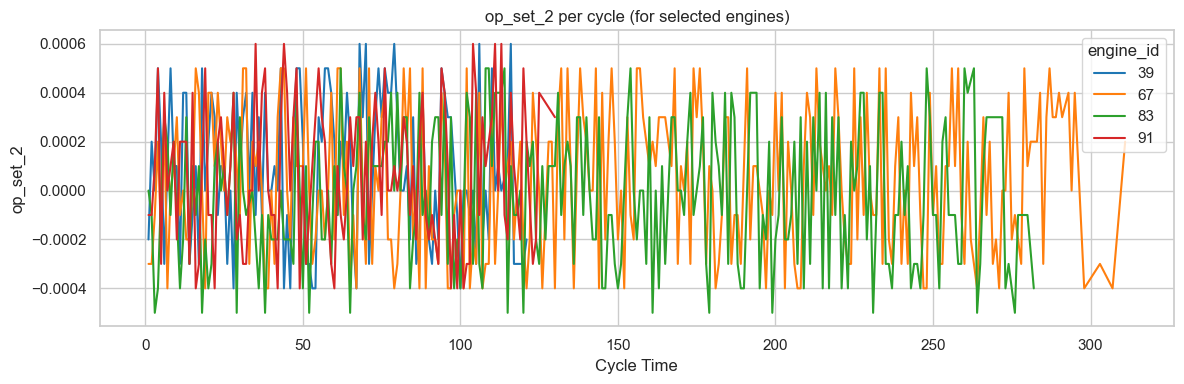

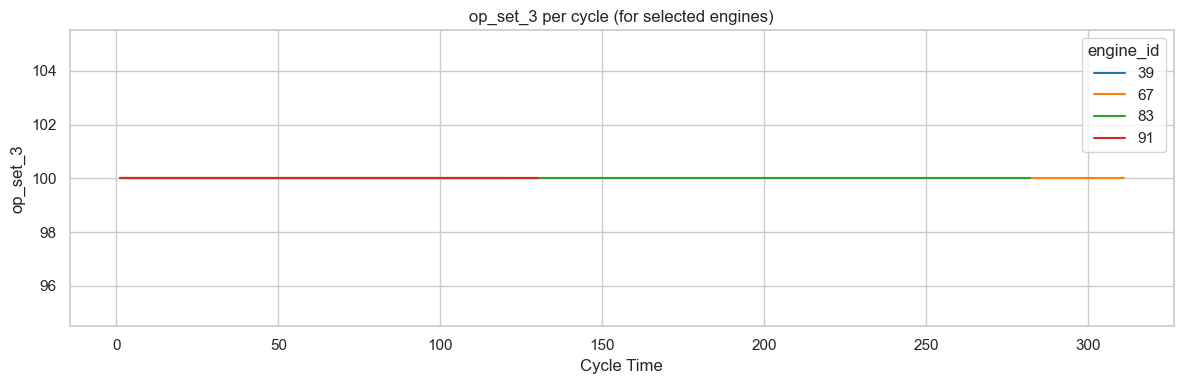

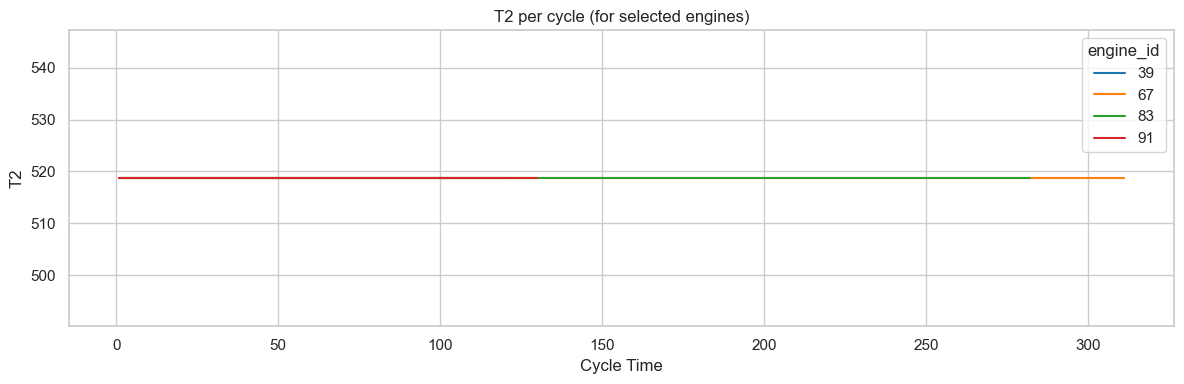

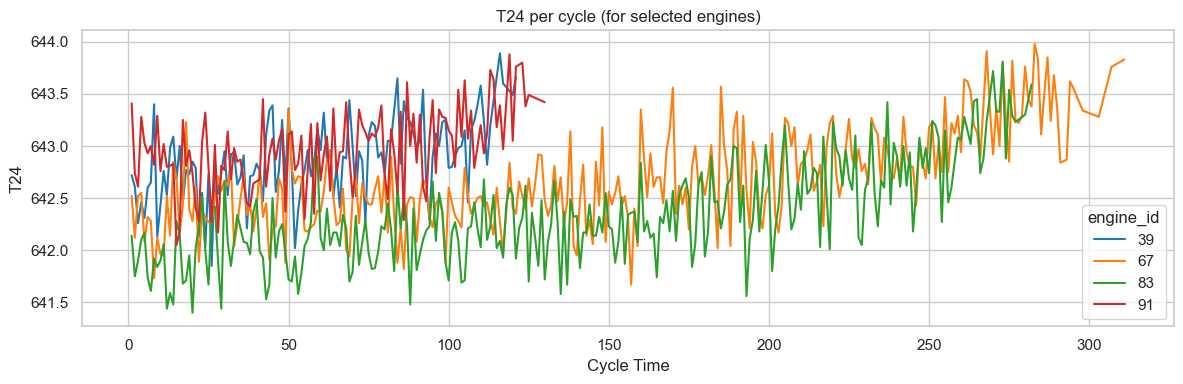

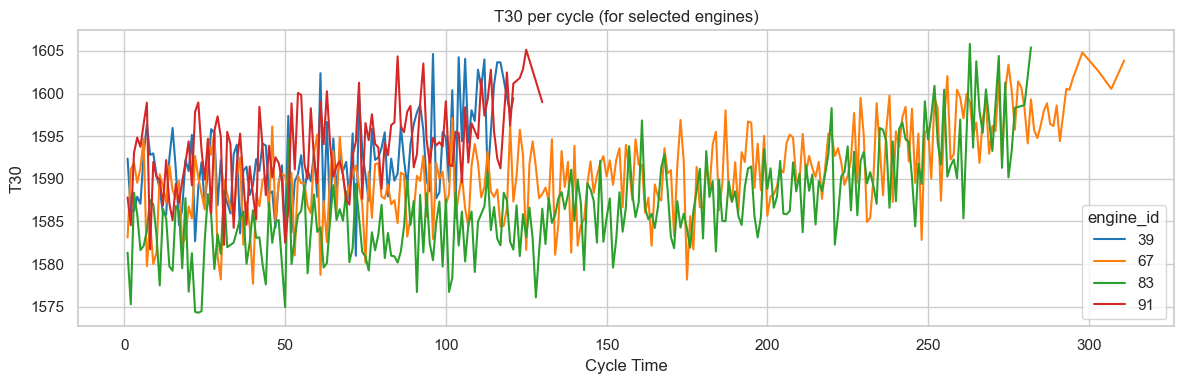

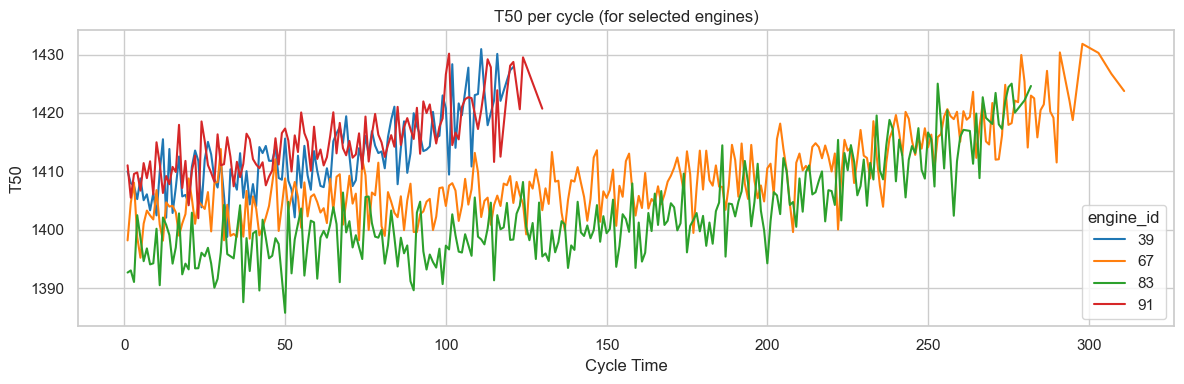

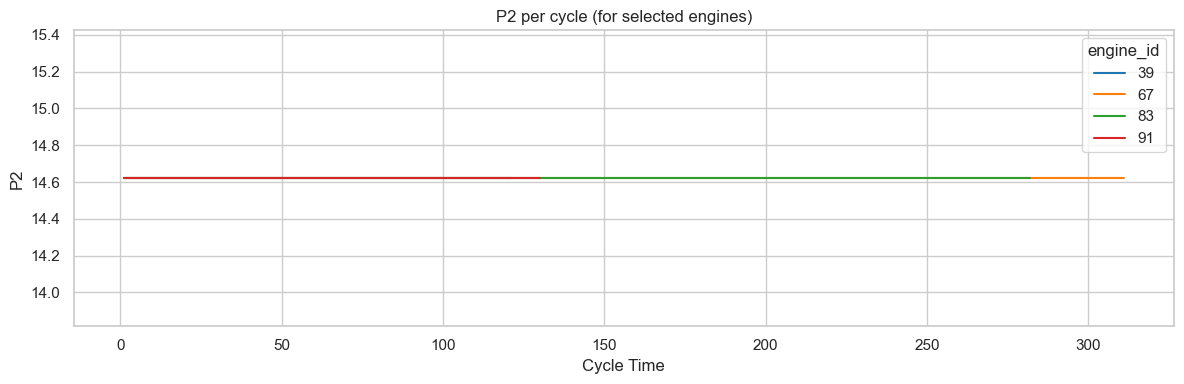

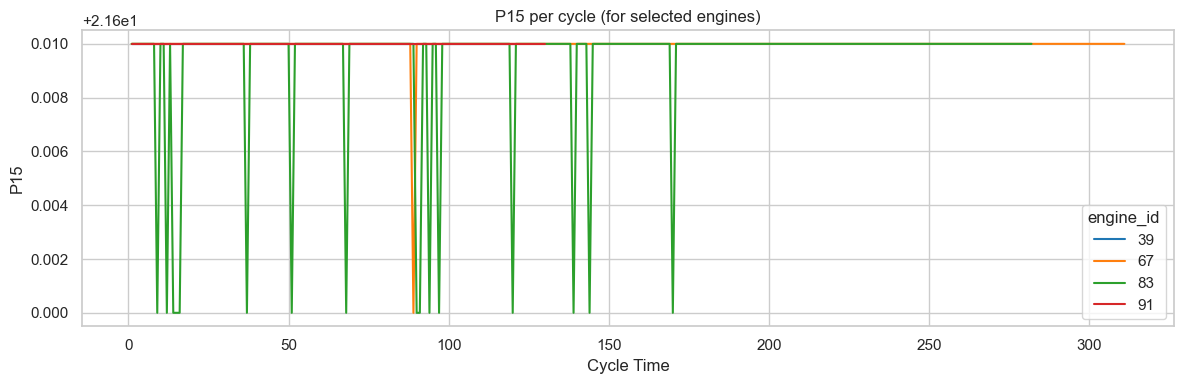

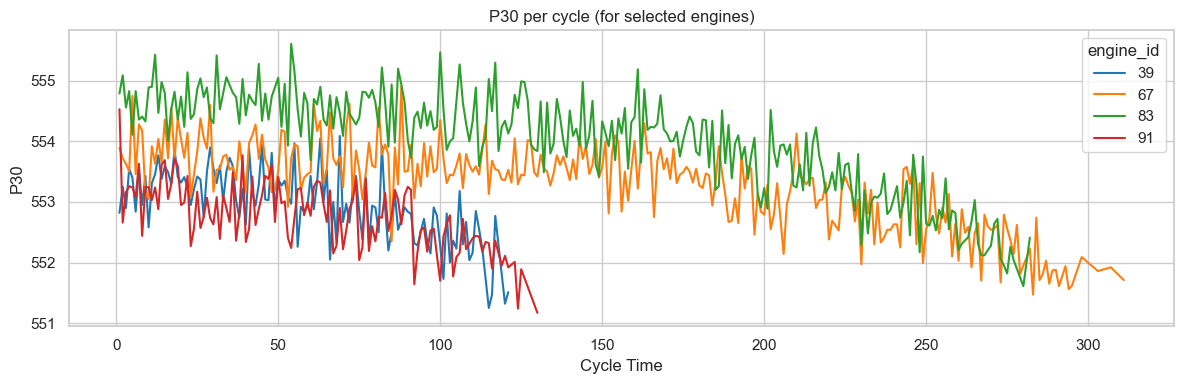

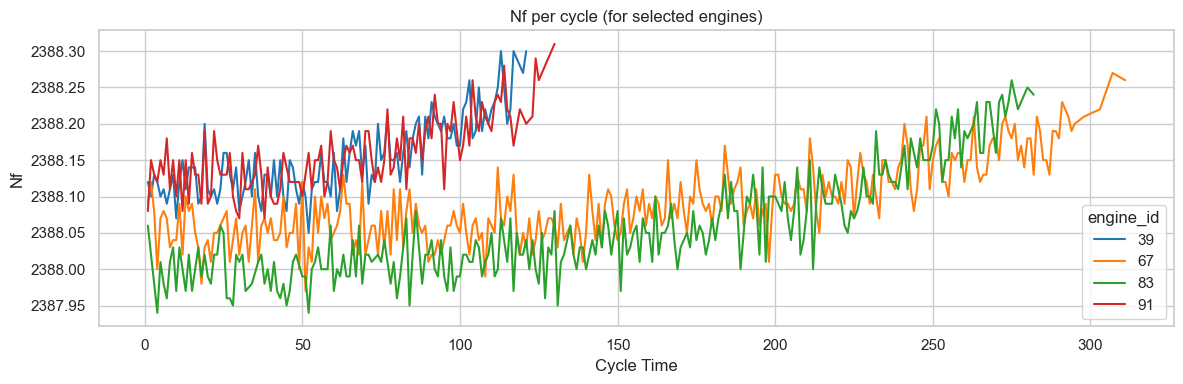

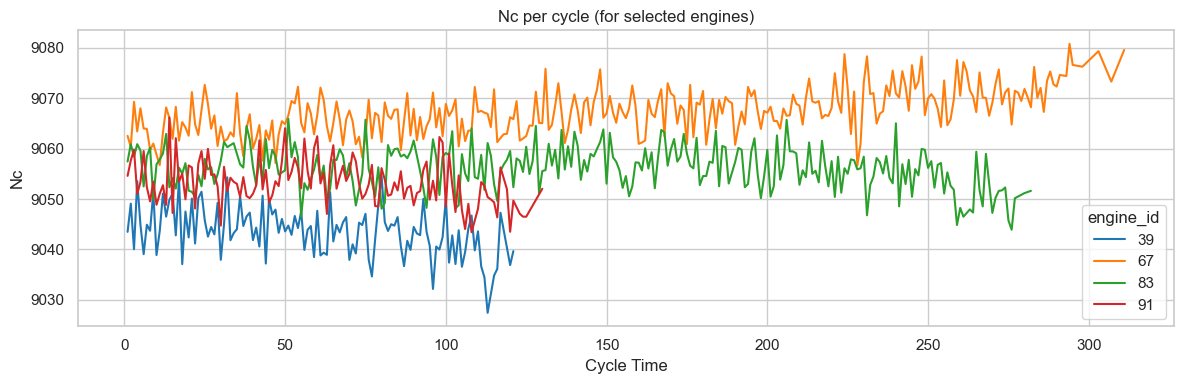

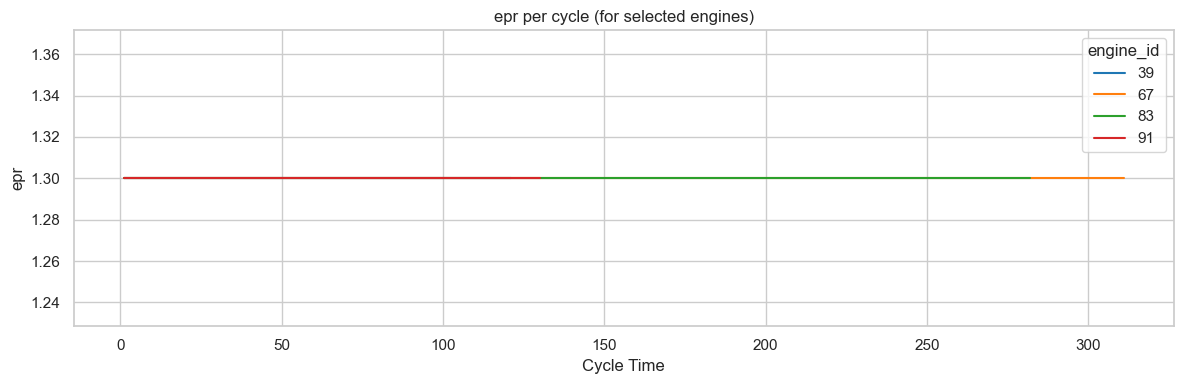

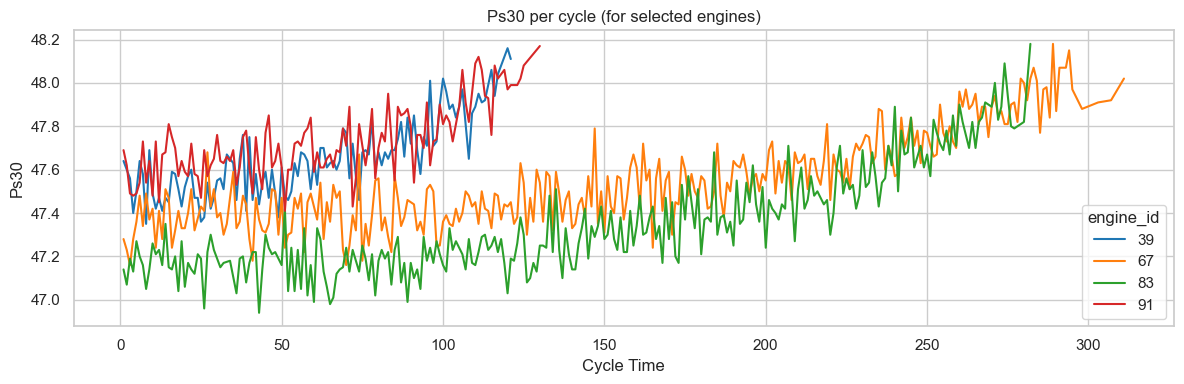

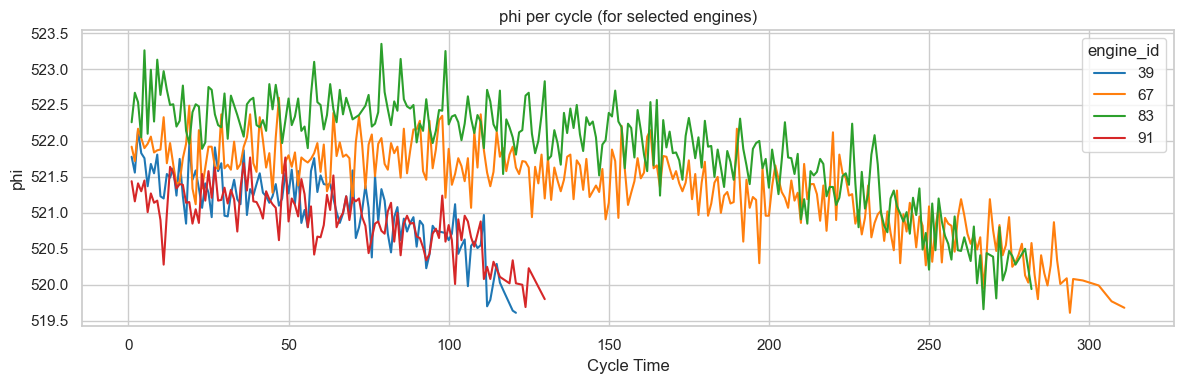

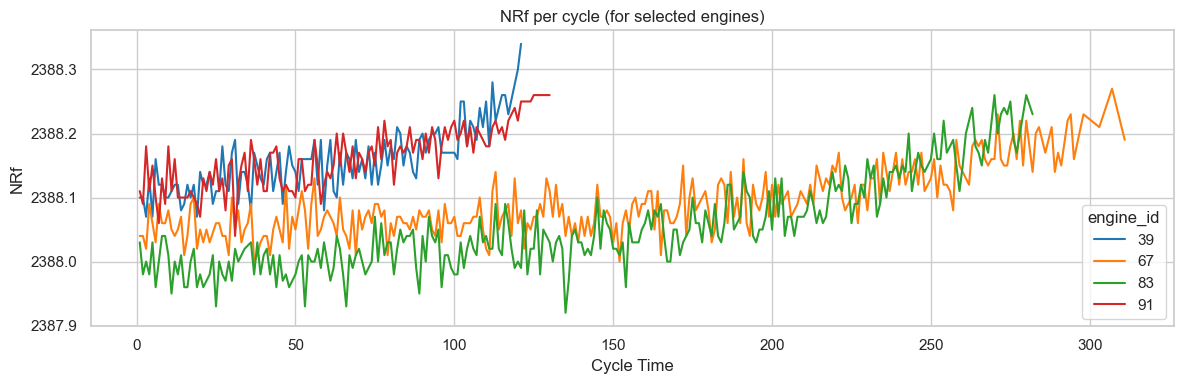

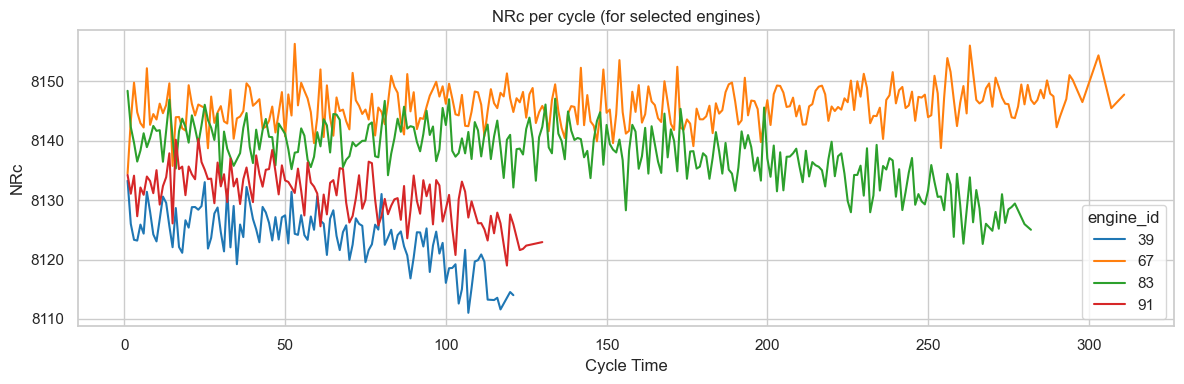

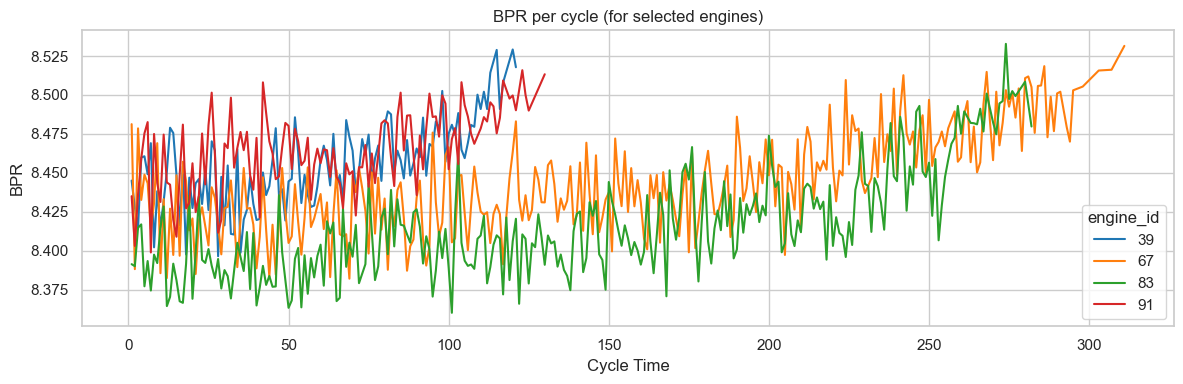

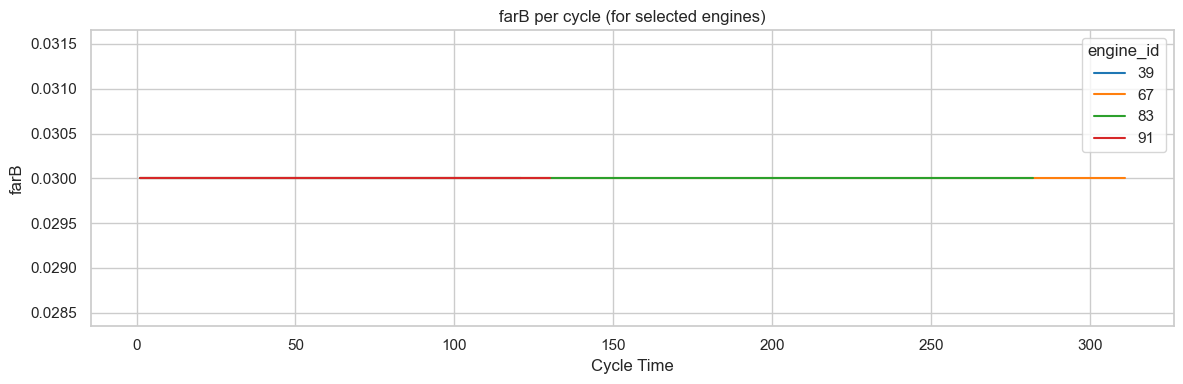

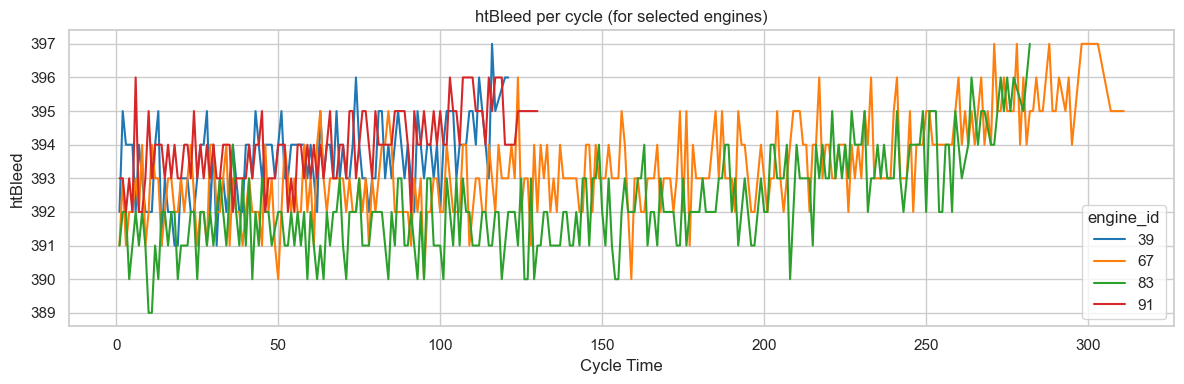

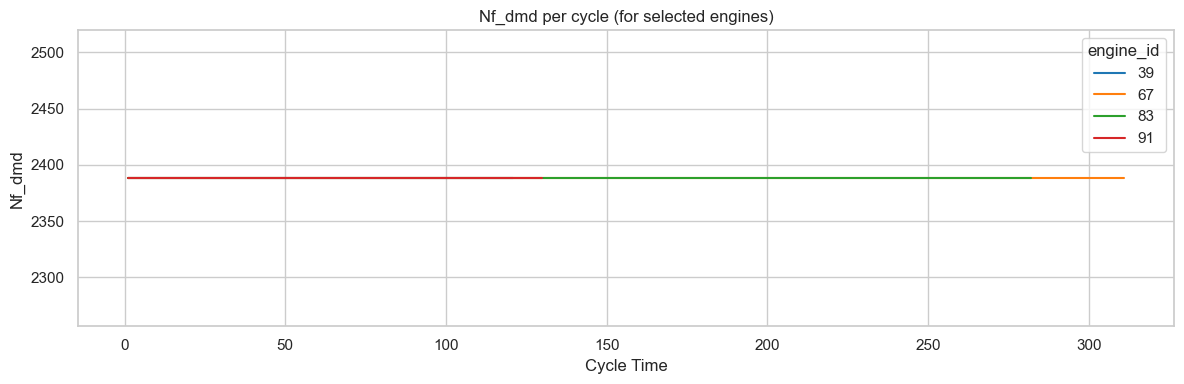

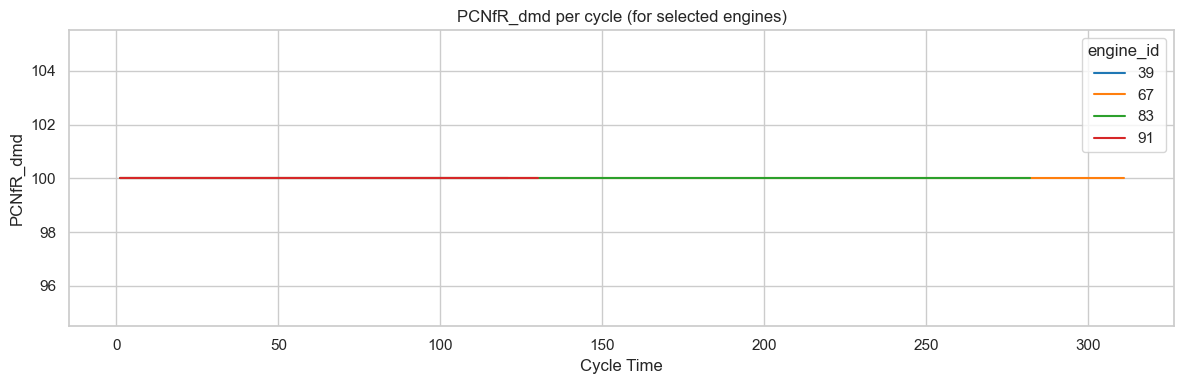

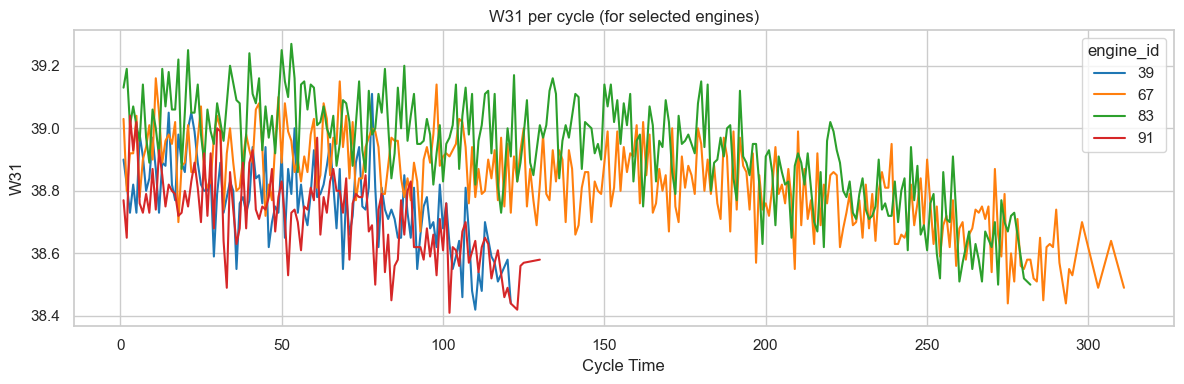

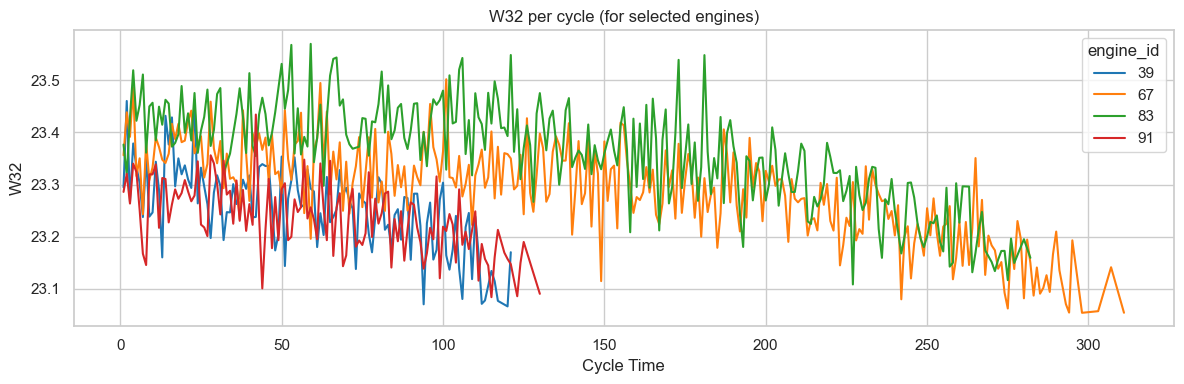

In [150]:
warnings.filterwarnings('ignore', category=FutureWarning, message='.*length-1 tuple.*')

metadata = ['engine_id', 'cycle_time',  'EOL', 'RUL']

# Define the palette and sensor columns
palette = sns.color_palette('tab10', len(engines))

sensors = [sensor for sensor in df_train.columns if sensor not in metadata]

# Plot each sensor readings over time for the selected engines
for sensor in sensors:
    plt.figure(figsize=(12, 4))
    sns.set_theme(style='whitegrid')
    sns.lineplot(
        data=df_train[df_train['engine_id'].isin(engines)],
        x='cycle_time', y=sensor,
        hue='engine_id', palette=palette
    )
    plt.title(f'{sensor} per cycle (for selected engines)')
    plt.xlabel('Cycle Time')
    plt.ylabel(sensor)
    plt.tight_layout()
    plt.show()

#### Analysis of Sensor Behavior
Certain sensor readings show strong correlation with engine degradation and potential failure:
- Temperature Sensors (T24, T30, T50): Failures often occur when temperatures exceed critical thresholds, indicating thermal stress or overheating.
- Pressure Sensor (P30): Engines tend to fail when pressure drops below operational limits, suggesting leakage or compressor inefficiency.
- Fan Speed Sensor (Nf): Failure events are observed when fan speed exceeds safe operating levels, possibly due to overuse or rotor imbalance.
- Static Pressure Sensor (Ps30): Elevated static pressure can indicate airflow restrictions or blockages, contributing to failure.
- Fuel/Air Ratio Sensor (phi): Failures often correlate with low fuel-air ratios, suggesting lean combustion and instability.
- Corrected Fan Speed Sensor (NRf): High corrected fan speed is associated with mechanical strain and impending failure.
- Corrected Core Speed Sensor (NRc): A decline in core speed may precede failure, likely reflecting engine core degradation.
- Bypass Ratio Sensor (BPR): Excessive bypass ratios are indicative of abnormal airflow distribution and potential system inefficiencies.
- Bleed Enthalpy Sensor (htBleed): High enthalpy values suggest inefficient thermal regulation, often preceding failure.
- Coolant Bleed Flow Sensors (W31, W32): Reduced coolant flow indicates cooling system degradation, increasing the risk of thermal failure.

In [152]:
features_to_drop = ['engine_id', 'op_set_1', 'op_set_2', 'op_set_3', 'T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd', 'EOL']

def drop_features(df, features_to_drop):
    '''
    Drops selected features from a dataframe.
    
    Returns a dataframe without selected features.
    '''
    
    df = df.drop(columns = features_to_drop)

    return df

df_train = drop_features(df_train, features_to_drop)

#### Training and Validation Set

In [154]:
# Select X and y from dataset
X = df_train.drop(columns=['RUL'])
y = df_train['RUL']

# Split dataset in training and validation set in 80/20 ratio
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_val.shape)

(14799, 15)
(3700,)


#### Data Pipeline

In [156]:
# Create data pipeline that imputes using mean and scales data
pipe = make_pipeline(
    SimpleImputer(strategy='mean').set_output(transform='pandas'),
    StandardScaler(),
)

# Pipeline used to transform training data and return a dataframe
X_train_transformed = pipe.fit_transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train.columns)

#### Model Building

##### Model Selection Rationale:
To identify the most effective RUL prediction approach, three regression models were explored based on their ability to handle complex data patterns, generalization performance, and speed of execution:

1. Support Vector Regressor (SVR): SVR is effective for high-dimensional datasets and can model non-linear relationships using kernel tricks. However, it is computationally expensive on large datasets and may struggle with scalability.


2. Random Forest Regressor: A powerful ensemble model that handles non-linearities and feature interactions well. It is robust to noise and overfitting, but can be slower in prediction and lacks native support for incremental learning.

3. LightGBM Regressor: A gradient boosting framework optimized for speed and performance. It handles large datasets efficiently, supports categorical features natively, and often provides state-of-the-art results with minimal tuning.

In [159]:
# Instatiate initial models to be explored
sr = SVR()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
lgb_model = lgb.LGBMRegressor(objective='regression', n_estimators=200, learning_rate=0.05, random_state=42)

# Use threefold cross validation
cv_scores_sr = -cross_val_score(sr, X_train_transformed, y_train, scoring='neg_root_mean_squared_error', cv=3)
cv_scores_rf = -cross_val_score(rf, X_train_transformed, y_train, scoring='neg_root_mean_squared_error', cv=3)
cv_scores_lgb = -cross_val_score(lgb_model, X_train_transformed, y_train, scoring='neg_root_mean_squared_error', cv=3)

# Compute the mean rmse from threefold cross validation for each model
rmse_sr = cv_scores_sr.mean()
rmse_rf = cv_scores_rf.mean()
rmse_lgb = cv_scores_lgb.mean()

# Display mean rmse values for each model
print('RMSE for Support Vector Regression model:', rmse_sr)
print('RMSE for Random Forest Regression model:', rmse_rf)
print('RMSE for LightGBM Regression model:', rmse_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2860
[LightGBM] [Info] Number of data points in the train set: 9866, number of used features: 15
[LightGBM] [Info] Start training from score 109.294040
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2859
[LightGBM] [Info] Number of data points in the train set: 9866, number of used features: 15
[LightGBM] [Info] Start training from score 109.079363
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2862
[LightGBM] [Info] Number of data points in the train set: 9866, number of used features: 15
[LightGBM] [Info] Start tr

##### Model chosen:
LightGBM was ultimately selected for the final implementation because it trained fairly quickly, has high predictive accuracy, and strong support for feature importance interpretation. It also performed better than both the Support Vector Regressor and the Random Forest Regressor during testing, making it the best overall choice for this project.

##### Hyerparameter tuning for best model (LightBGM)

In [162]:
# Create parameter grid of hyperparamters
param_grid_lgb = {
    'n_estimators': [100, 200],
    'max_depth': [-1, 5, 10],
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.05],
    'min_child_samples': [20, 50],
    'subsample': [1.0],
    'colsample_bytree': [1.0]
}

# Instantiate the best performing model from previous step
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42)

# Define grid search and parameters
grid_search_lgb = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid_lgb,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Train the model
grid_search_lgb.fit(X_train_transformed, y_train)

# Output best parameters and RMSE
print("Best Parameters for LightGBM:", grid_search_lgb.best_params_)
print("Best RMSE for LightGBM:", -grid_search_lgb.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2862
[LightGBM] [Info] Number of data points in the train set: 9866, number of used features: 15
[LightGBM] [Info] Start training from score 109.451247
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, min_child_samples=20, n_estimators=100, num_leaves=50, subsample=1.0; total time=   4.8s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2859
[LightGBM] [Info] Number of data points in the train set: 9866, number of used features: 15
[LightGBM] [Info] Start training from score 109.079363
[CV] END colsample_bytree=1.0, lear

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 14799, number of used features: 15
[LightGBM] [Info] Start training from score 109.274883
Best Parameters for LightGBM: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 50, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 1.0}
Best RMSE for LightGBM: 31.22405593321237


##### Training model with best parameters

In [164]:
# Training the LightGBM regressor with best hyperparameters
lgb_model = lgb.LGBMRegressor(objective='regression', 
                              n_estimators=200, 
                              learning_rate=0.05, 
                              max_depth=5, 
                              colsample_bytree= 1.0, 
                              min_child_samples=50,
                              num_leaves=50,
                              subsample=1.0,
                              random_state=42)

lgb_model.fit(X_train_transformed, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 14799, number of used features: 15
[LightGBM] [Info] Start training from score 109.274883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

LGBMRegressor(learning_rate=0.05, max_depth=5, min_child_samples=50,
              n_estimators=200, num_leaves=50, objective='regression',
              random_state=42)

##### Training Set Evaluation

In [166]:
# Make predictions using trained model
pred_train = lgb_model.predict(X_train_transformed)

# Evalute model using rmse, mae and r2 score
rmse_train = root_mean_squared_error(y_train, pred_train)
mae_train = mean_absolute_error(y_train, pred_train)
r2_train = r2_score(y_train, pred_train)

# Print evaluation values
print('RMSE for training set:', rmse_train)
print('MAE for training set:', mae_train)
print('R2 score for training set:', r2_train)

RMSE for training set: 28.446022284703574
MAE for training set: 20.534974838915463
R2 score for training set: 0.7935543008118461


##### Validation Set Evaluation

In [168]:
# Transform the validation dataset
X_val_transformed = pipe.transform(X_val)
X_val_transformed = pd.DataFrame(X_val_transformed, columns=X_val.columns)

# Make predictions using trained model
pred_val = lgb_model.predict(X_val_transformed)

# Evalute model using rmse, mae and r2 score
rmse_val = root_mean_squared_error(y_val, pred_val)
mae_val = mean_absolute_error(y_val, pred_val)
r2_val = r2_score(y_val, pred_val)

# Print evaluation values
print('RMSE for validation set:', rmse_val)
print('MAE for validation set:', mae_val)
print('R2 score for validation set:', r2_val)

RMSE for validation set: 30.97666460252916
MAE for validation set: 22.47614851622415
R2 score for validation set: 0.7477534992911646


##### Testing Set Evaluation

In [170]:
# Preparing the test dataset
# Ground truth (y_test) is RUL values for each engine in test set
y_test = df_RUL

# Extract the last cycle for each engine which would correspond to the RUL values
X_test = df_test.groupby('engine_id').last().reset_index()

# Drop unnecessary features
features_to_drop = ['engine_id', 'op_set_1', 'op_set_2', 'op_set_3', 'T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd']
X_test = drop_features(X_test, features_to_drop)

# Transform the test input data
X_test_transformed = pipe.transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=X_test.columns)

# Make predictions using trained model
pred_test = lgb_model.predict(X_test_transformed)

# Evalute model using rmse, mae and r2 score
rmse_test = root_mean_squared_error(y_test, pred_test)
mae_test = mean_absolute_error(y_test, pred_test)
r2_test = r2_score(y_test, pred_test)

# Print evaluation values
print('RMSE for test set:', rmse_test)
print('MAE for validation set:', mae_test)
print('R2 score for test set:', r2_test)

RMSE for test set: 24.310269351762322
MAE for validation set: 18.00987619303446
R2 score for test set: 0.6577684870037468


#### RUL Predictions with Confidence Interval

In [172]:
# Lower quantile model
lgb_lower = lgb.LGBMRegressor(objective='quantile',
                              alpha=0.05,
                              n_estimators=200,
                              learning_rate=0.05,
                              max_depth=5,
                              colsample_bytree=1.0,
                              min_child_samples=50,
                              num_leaves=50,
                              subsample=1.0,
                              random_state=42)

lgb_lower.fit(X_train_transformed, y_train)
pred_lower = lgb_lower.predict(X_test_transformed)

# Upper quantile model
lgb_upper = lgb.LGBMRegressor(objective='quantile',
                              alpha=0.95,
                              n_estimators=200,
                              learning_rate=0.05,
                              max_depth=5,
                              colsample_bytree=1.0,
                              min_child_samples=50,
                              num_leaves=50,
                              subsample=1.0,
                              random_state=42)

lgb_upper.fit(X_train_transformed, y_train)
pred_upper = lgb_upper.predict(X_test_transformed)

# Point prediction is prediction made from original model
pred_point = pred_test

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 14799, number of used features: 15
[LightGBM] [Info] Start training from score 18.900011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [173]:
# Display RUL with confidence interval for the first 'i' engines
for i in range(5):
    print(f'Engine {i+1}: Predicted RUL = {pred_point[i]:.2f}, 90% CI = ({pred_lower[i]:.2f}, {pred_upper[i]:.2f})')

Engine 1: Predicted RUL = 162.18, 90% CI = (104.36, 228.67)
Engine 2: Predicted RUL = 150.11, 90% CI = (91.37, 205.97)
Engine 3: Predicted RUL = 53.15, 90% CI = (24.63, 120.01)
Engine 4: Predicted RUL = 82.73, 90% CI = (42.05, 158.26)
Engine 5: Predicted RUL = 98.50, 90% CI = (41.16, 174.58)


#### Analysis

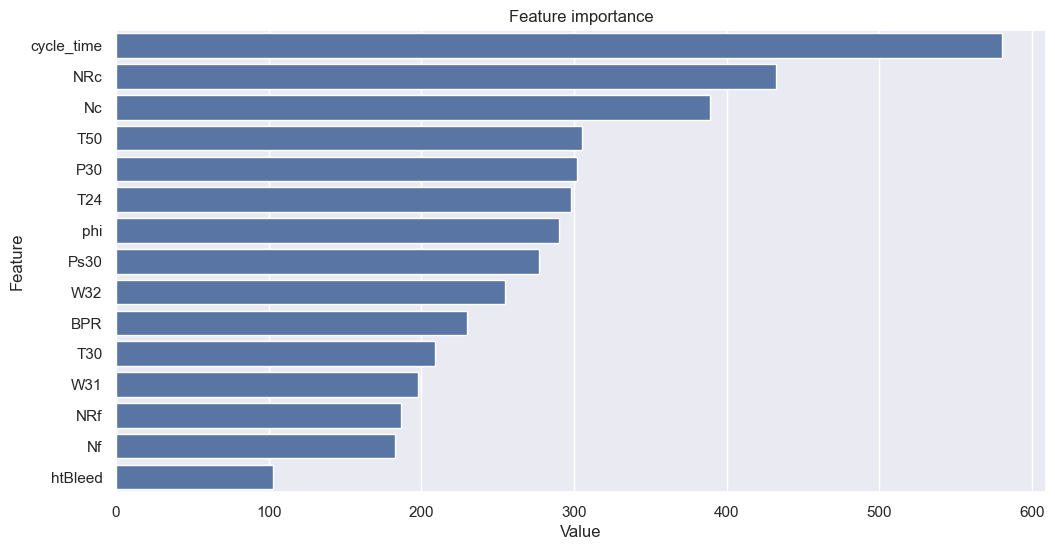

In [175]:
# Plot feature importance (LGBM)
feature_importance = pd.DataFrame(sorted(zip(lgb_model.feature_importances_, X_train_transformed.columns)), columns=['Value','Feature'])

plt.figure(figsize=(12, 6))
sns.set_theme()
sns.barplot(data=feature_importance.sort_values(by='Value', ascending=False), x='Value', y='Feature')
plt.title('Feature importance')
plt.show()

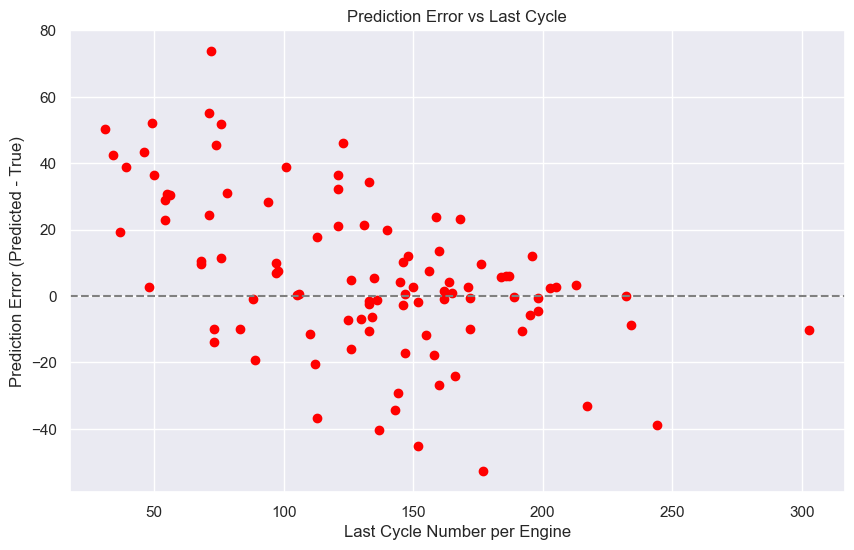

In [176]:
# Create Series with truth values for RUL
true_RUL = df_RUL['RUL']

# Compute error
prediction_error = pred_test - true_RUL

# Get last cycle per engine
last_cycles = df_test.groupby('engine_id')['cycle_time'].max().reset_index()['cycle_time']

# Plot Prediction Error
plt.figure(figsize=(10, 6))
plt.scatter(last_cycles, prediction_error, c='red')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Last Cycle Number per Engine')
plt.ylabel('Prediction Error (Predicted - True)')
plt.title('Prediction Error vs Last Cycle')
plt.grid(True)
plt.show()

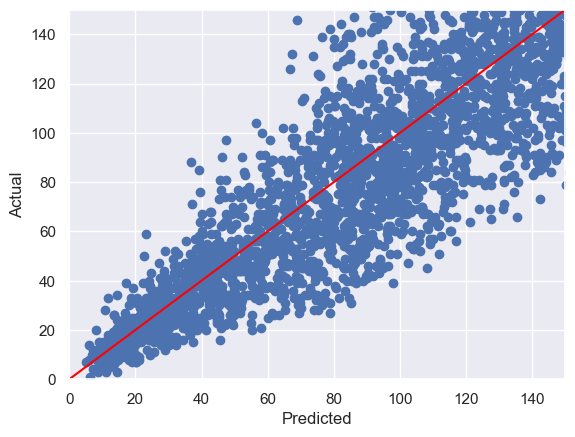

In [177]:
# Validation Set Analysis
plt.figure()
plt.scatter(x=pred_val, y=y_val)
sns.lineplot(x = [0, 150], y = [0, 150], color = 'red')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xlim([0,150])
plt.ylim([0,150])
plt.show()

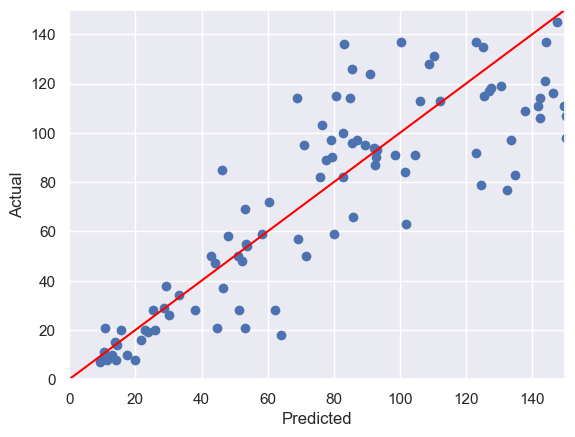

In [178]:
# Test Set Analysis
plt.figure()
plt.scatter(x=pred_test, y=y_test)
sns.lineplot(x = [0, 150], y = [0, 150], color = 'red')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xlim([0,150])
plt.ylim([0,150])
plt.show()

In [179]:
# Explore RUL stats
print('Mean RUL value:', y_test['RUL'].mean())
print('Median RUL value:', y_test['RUL'].median())
print('Minimum RUL value:', y_test['RUL'].min())
print('Maximum RUL value:', y_test['RUL'].max())

Mean RUL value: 75.52
Median RUL value: 86.0
Minimum RUL value: 7
Maximum RUL value: 145


##### Maintenance Predicitions

In [181]:
# Define cutoff
rul_threshold = 15

# True labels: 1 if RUL <= 15 (maintenance needed), else 0
y_true_class = (y_test['RUL'] <= rul_threshold).astype(int)

# Predicted labels: 1 if predicted RUL <= 15, else 0
y_pred_class = (pred_test <= rul_threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y_true_class, y_pred_class)
print('Confusion Matrix:', cm)

# Classification report
print('Classification Report:', classification_report(y_true_class, y_pred_class, target_names=['Healthy (>15)', 'Maintenance Needed (≤15)']))

Confusion Matrix: [[89  1]
 [ 2  8]]
Classification Report:                           precision    recall  f1-score   support

           Healthy (>15)       0.98      0.99      0.98        90
Maintenance Needed (≤15)       0.89      0.80      0.84        10

                accuracy                           0.97       100
               macro avg       0.93      0.89      0.91       100
            weighted avg       0.97      0.97      0.97       100



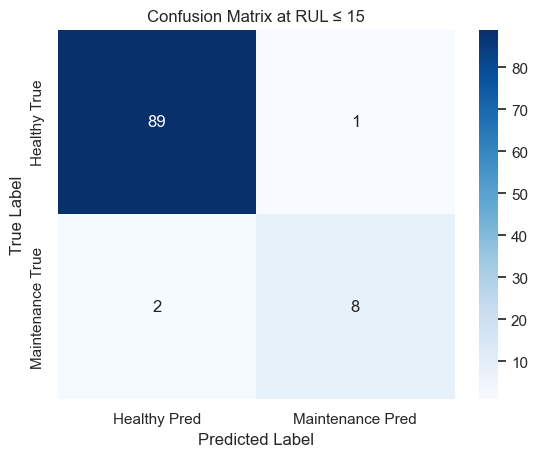

In [182]:
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=['Healthy Pred', 'Maintenance Pred'],
yticklabels=['Healthy True', 'Maintenance True'])
plt.title('Confusion Matrix at RUL ≤ 15')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [183]:
# Define cutoff
rul_threshold = 47

# True labels: 1 if RUL <= 47 (maintenance needed), else 0
y_true_class = (y_test['RUL'] <= rul_threshold).astype(int)

# Predicted labels: 1 if predicted RUL <= 47, else 0
y_pred_class = (pred_test <= rul_threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y_true_class, y_pred_class)
print("Confusion Matrix:", cm)

# Classification report
print("Classification Report:", classification_report(y_true_class, y_pred_class, target_names=['Healthy (>47)', 'Maintenance Needed (≤47)']))

Confusion Matrix: [[69  2]
 [ 4 25]]
Classification Report:                           precision    recall  f1-score   support

           Healthy (>47)       0.95      0.97      0.96        71
Maintenance Needed (≤47)       0.93      0.86      0.89        29

                accuracy                           0.94       100
               macro avg       0.94      0.92      0.93       100
            weighted avg       0.94      0.94      0.94       100



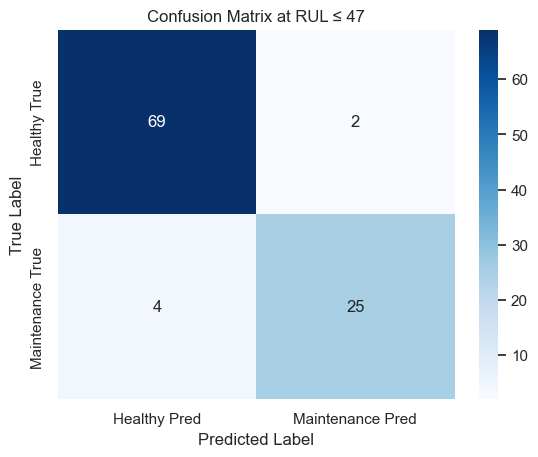

In [184]:
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=['Healthy Pred', 'Maintenance Pred'],
yticklabels=['Healthy True', 'Maintenance True'])
plt.title('Confusion Matrix at RUL ≤ 47')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

##### Analysis Summary
The features that had the greatest impact on the model were:

1. cycle_time – Duration of engine usage in cycles
2. NRc – Corrected core speed
3. Nc – Physical core speed
4. T50 – Total temperature at the low-pressure turbine outlet
5. P30 – Pressure at the high-pressure compressor outlet

The model demonstrates balanced prediction performance for engines with longer operational lifespans — especially those with last cycle counts greater than 99. In these cases, prediction errors are relatively balanced, indicating reliable RUL forecasts.

However, for engines that fail early (before 100 cycles), the model shows a consistent bias toward overestimating the Remaining Useful Life (RUL). This may be due to:

- A training set composed of full run-to-failure cycles, leading the model to learn more from longer-lived engines
- Fewer degradation patterns available for engines with shorter lifespans

Predictive model: LightGBM for regression of RUL Mapping maintenance flag if RUL <= 15
- Accuracy of model: 97%
- Recall: 80%
- Precision: 89%

Predictive model: LightGBM for regression of RUL Mapping maintenance flag if RUL <= 47
- Accuracy of model: 94%
- Recall: 86%
- Precision: 93%

#### Conclusion
The Remaining Useful Life (RUL) prediction system using LightGBM demonstrates strong performance, particularly for engines with longer operational histories. With prediction accuracy reaching 97% and high precision (89–93%), the model is well-suited for flagging engines approaching end-of-life.

However, the consistent overestimation bias for short-lived engines presents a critical risk for early failures. By fine-tuning the RUL decision threshold—such as flagging engines when RUL ≤ 47 (start monitoring) and considering RUL ≤ 15 as a critical state—the trade-off between precision and recall can be adjusted based on the maintenance team’s risk tolerance.

This model can be immediately applied in maintenance planning by:

- Proactively flagging engines below a dynamic RUL threshold
- Prioritizing inspections based on predicted risk levels
- Reducing unplanned downtime through data-driven scheduling

##### Limitations and Ideas for Further Improvement
1. Class Imbalance: Reweight short-lived engines during training to prevent underperformance on fast-degrading units.
2. Early Degradation Signals: Engineer features that capture early warning trends or sensor instability.
3. Temporal Modeling: Integrate sequence-based models (e.g., LSTM) to better capture degradation over time.
4. Sensor Noise and Drift: Apply smoothing or filtering techniques to correct for sensor noise and calibration drift.
5. Dynamic Maintenance Thresholds: Improve RUL-to-flag mapping using cost, operational risk, and asset-specific context.
6. Business Optimization: Incorporate cost-based optimization or maintenance scheduling constraints to maximize real-world impact.